Bert + MLP


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Cuda kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

df = pd.read_csv('dataset.csv')

labels = pd.read_csv("dataset.csv")
labels = labels["label"].values.tolist()

Kullanılan cihaz: cuda


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
import os

#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
tokenizer2 = AutoTokenizer.from_pretrained("TURKCELL/roberta-base-turkish-uncased")

metinler = df["text"].values.tolist()

# Tokenize et ve attention mask'i al
encodings = tokenizer2(
    metinler,
    padding=True,
    truncation=True,
    max_length=512,  # Bu satırı ekleyin
    return_tensors='pt'
)
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/976k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/634k [00:00<?, ?B/s]

In [ ]:
# Sabit değerler
MAX_LEN = 128
BATCH_SIZE = 96
EPOCHS = 10
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "dbmdz/bert-base-turkish-cased"  # BERTurk modeli
MODEL_NAME2 = "TURKCELL/roberta-base-turkish-uncased"  # TARBERT

Class Weight yerine Focal Loss kullanımı

Kullanılan cihaz: cuda
TF-IDF özellik boyutu: (35530, 5000)
Epoch 1/100
Train Loss: 0.7745, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7605, Val F1: 0.0455, Val Class 1 F1: 0.2796
Epoch 2/100
Train Loss: 0.7587, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7436, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7375, Train F1: 0.0507, Train Class 1 F1: 0.2803
Val Loss: 0.7237, Val F1: 0.0625, Val Class 1 F1: 0.2817
Validation score improved! Overall F1: 0.0625, Class 1 F1: 0.2817
Epoch 4/100
Train Loss: 0.7155, Train F1: 0.0618, Train Class 1 F1: 0.2816
Val Loss: 0.7033, Val F1: 0.0645, Val Class 1 F1: 0.2819
EarlyStopping counter: 1 out of 10
Epoch 5/100
Train Loss: 0.6941, Train F1: 0.0756, Train Class 1 F1: 0.2833
Val Loss: 0.6820, Val F1: 0.0820, Val Class 1 F1: 0.2841
Validation score improved! Overall F1: 0.0820, Class 1 F1: 0.2841
Epoch 6/100
Train Loss: 0.6701, Train F1: 0.0948, Train Class 1 F1: 0.2857
Val

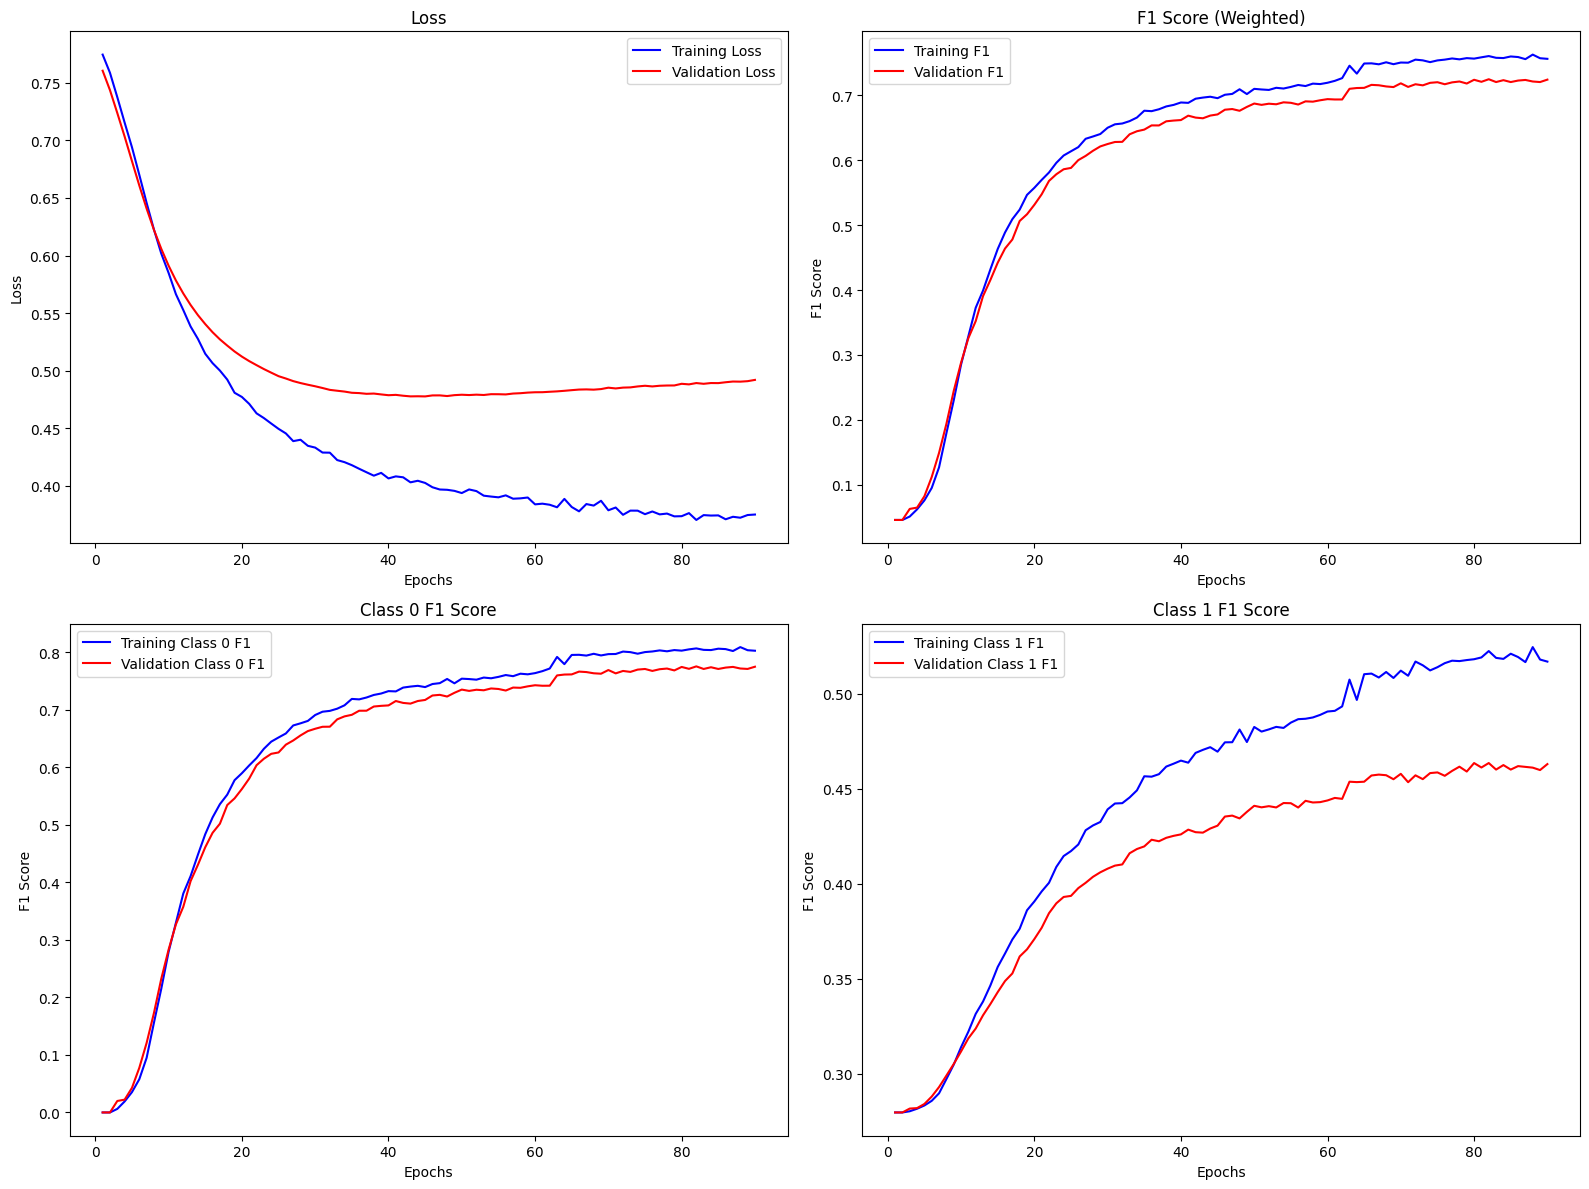

Evaluation Results:
Accuracy: 0.6828
F1 Score (Weighted): 0.7242
F1 Score for Class 1: 0.4636
Confusion Matrix:
[[3878, 2073], [181, 974]]

Test Metrics:
Overall F1 score: 0.7242
Class 1 F1 score: 0.4636
Accuracy: 0.6828
Confusion Matrix:
[[3878, 2073], [181, 974]]

Model ağırlıkları 'best_tfidf_mlp.pt' dosyasına kaydedildi.
TF-IDF vektörleştirici 'tfidf_vectorizer.pkl' dosyasına kaydedildi.


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import copy
import joblib

# Cuda kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Sabit değerler
BATCH_SIZE = 96
EPOCHS = 100
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_FEATURES = 5000  # TF-IDF için maksimum özellik sayısı

class TFIDFMLPEnsemble(nn.Module):
    def __init__(self, input_size, dropout_rate=DROPOUT_RATE):
        super(TFIDFMLPEnsemble, self).__init__()
        # Path A: TF-IDF -> Dense(128) -> Relu -> Dense -> Output

        # TF-IDF'ten sonraki MLP kısmı
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, 2)  # Binary classification

    def forward(self, tfidf_features):
        # TF-IDF özelliklerini kullanarak ileri yayılım
        x = self.dropout(tfidf_features)

        # MLP kısmı
        dense_output = self.dense(x)
        relu_output = self.relu(dense_output)
        logits = self.classifier(relu_output)

        return logits

class CustomTFIDFDataset(Dataset):
    def __init__(self, tfidf_features, labels=None):
        self.tfidf_features = tfidf_features
        self.labels = labels

    def __len__(self):
        return len(self.tfidf_features)

    def __getitem__(self, idx):
        item = {
            'tfidf_features': torch.tensor(self.tfidf_features[idx], dtype=torch.float)
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight factor for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = nn.functional.log_softmax(inputs, dim=1)
        ce_loss = nn.functional.nll_loss(log_softmax, targets, weight=self.alpha, reduction='none')

        # Get the probabilities for the target class
        p_t = torch.exp(-ce_loss)

        # Apply the focusing term
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EarlyStoppingWithClassF1:
    def __init__(self, patience=5, min_delta=0.001, class_index=1, class_weight=0.5):
        """
        Early stopping that monitors both overall F1 and Class 1 F1 scores

        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change in monitored metrics to qualify as improvement
            class_index: Index of the class to monitor (1 for Class 1)
            class_weight: Weight given to class F1 vs overall F1 (0.5 means equal weight)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.class_index = class_index
        self.class_weight = class_weight
        self.counter = 0
        self.best_score = None
        self.best_class_f1 = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, model, val_overall_f1, val_class_f1s):
        """
        Args:
            model: Model to save if improvement
            val_overall_f1: Overall validation F1 score
            val_class_f1s: F1 scores for each class (list or array)
        """
        # Get the F1 score for the specific class we're monitoring
        class_f1 = val_class_f1s[self.class_index]

        # Calculate a combined score that considers both overall F1 and class F1
        combined_score = (1 - self.class_weight) * val_overall_f1 + self.class_weight * class_f1

        if self.best_score is None or self.best_class_f1 is None:
            # First epoch
            self.best_score = combined_score
            self.best_class_f1 = class_f1
            self.save_checkpoint(model)
        elif combined_score < self.best_score + self.min_delta:
            # Score didn't improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Score improved, but also check if Class 1 F1 didn't decrease significantly
            class_f1_decrease = self.best_class_f1 - class_f1

            # Only consider it an improvement if Class 1 F1 didn't drop too much
            if class_f1_decrease <= self.min_delta:
                print(f'Validation score improved! Overall F1: {val_overall_f1:.4f}, Class 1 F1: {class_f1:.4f}')
                self.best_score = combined_score
                self.best_class_f1 = class_f1
                self.save_checkpoint(model)
                self.counter = 0
            else:
                # Class 1 F1 dropped too much, don't reset counter
                print(f'Overall score improved but Class 1 F1 dropped too much (from {self.best_class_f1:.4f} to {class_f1:.4f})')
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        """Save model weights when validation performance improves"""
        self.best_weights = copy.deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        """Restore model to best weights"""
        model.load_state_dict(self.best_weights)

def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                num_epochs=10, patience=3, class_f1_weight=0.6, learning_rate=2e-5):
    """
    Train model with Focal Loss and balanced early stopping

    Args:
        model: Model to train
        train_dataloader: Training data loader
        test_dataloader: Validation/test data loader
        class_weights: Dictionary mapping class indices to weights (e.g., {0: 1, 1: 6})
        gamma: Focal loss focusing parameter
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience
        class_f1_weight: Weight to give to Class 1 F1 score in early stopping
        learning_rate: Learning rate for optimizer

    Returns:
        trained_model: The trained model
        history: Dictionary containing training metrics
    """
    # Set up device
    device = next(model.parameters()).device

    # Create alpha tensor for focal loss based on class weights
    if class_weights is not None:
        num_classes = len(class_weights)
        alpha = torch.ones(num_classes)
        for cls_idx, weight in class_weights.items():
            alpha[cls_idx] = weight
        alpha = alpha.to(device)
    else:
        alpha = None

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up early stopping
    early_stopping = EarlyStoppingWithClassF1(
        patience=patience,
        class_index=1,  # Monitor Class 1 F1
        class_weight=class_f1_weight
    )

    # Track metrics
    history = {
        'train_loss': [],
        'train_f1': [],
        'train_class_f1s': [],
        'val_loss': [],
        'val_f1': [],
        'val_class_f1s': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in train_dataloader:
            tfidf_features = batch['tfidf_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(tfidf_features)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_class_f1s = f1_score(train_labels, train_preds, average=None)

        # Save training metrics
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_class_f1s'].append(train_class_f1s.tolist())

        # Validation phase
        if test_dataloader is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for batch in test_dataloader:
                    tfidf_features = batch['tfidf_features'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(tfidf_features)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss = val_loss / len(test_dataloader)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_class_f1s = f1_score(val_labels, val_preds, average=None)

            # Save validation metrics
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_class_f1s'].append(val_class_f1s.tolist())

            # Print epoch results
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Class 1 F1: {val_class_f1s[1]:.4f}')

            # Early stopping check
            early_stopping(model, val_f1, val_class_f1s)

            if early_stopping.early_stop:
                print("Early stopping triggered")
                # Restore best weights
                early_stopping.restore_best_weights(model)
                break
        else:
            # Print training metrics when no validation set provided
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')

    # Load best weights if early stopping was used
    if test_dataloader is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)

    return model, history

def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model performance

    Args:
        model: Trained model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            tfidf_features = batch['tfidf_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(tfidf_features)

            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_by_class': f1_score(all_labels, all_preds, average=None),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds).tolist(),
        'classification_report': classification_report(all_labels, all_preds, output_dict=True)
    }

    # Add loss if criterion was provided
    if criterion is not None:
        metrics['loss'] = total_loss / len(dataloader)

    # Print key metrics
    print(f"Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score for Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics

def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer val_loss yoksa, sadece train metriklerini çizdir
    has_val = "val_loss" in history and len(history["val_loss"]) > 0

    # Loss grafiği
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_val:
        plt.plot(epochs, history["val_loss"], 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_val:
        plt.plot(epochs, history["val_f1"], 'r-', label='Validation F1')
    plt.title('F1 Score (Weighted)')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 0
    plt.subplot(2, 2, 3)
    train_class_0_f1 = [f1s[0] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_0_f1, 'b-', label='Training Class 0 F1')
    if has_val:
        val_class_0_f1 = [f1s[0] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_0_f1, 'r-', label='Validation Class 0 F1')
    plt.title('Class 0 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 1
    plt.subplot(2, 2, 4)
    train_class_1_f1 = [f1s[1] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_1_f1, 'b-', label='Training Class 1 F1')
    if has_val:
        val_class_1_f1 = [f1s[1] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_1_f1, 'r-', label='Validation Class 1 F1')
    plt.title('Class 1 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('tfidf_mlp_training_history.png')
    plt.show()


df = pd.read_csv('dataset.csv')
texts = df["text"].values.tolist()
labels = df["label"].values.tolist()

# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),  # Unigram ve bigram
    lowercase=True,
    max_df=0.95,  # Çok yaygın kelimeleri filtrele
    min_df=2      # Çok nadir kelimeleri filtrele
)

# TF-IDF özelliklerini oluştur
tfidf_features = tfidf_vectorizer.fit_transform(texts).toarray()
print(f"TF-IDF özellik boyutu: {tfidf_features.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Dataset ve DataLoader oluşturma
train_dataset = CustomTFIDFDataset(X_train, y_train)
test_dataset = CustomTFIDFDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Model oluşturma - girdi boyutu TF-IDF özellik boyutu
model = TFIDFMLPEnsemble(input_size=MAX_FEATURES, dropout_rate=DROPOUT_RATE).to(DEVICE)

# Sınıf ağırlığı ve Focal Loss parametreleri
class_weights = {0: 1, 1: 6}  # Sınıf dengesizliğine göre
gamma = 2.0  # Focal Loss focusing parametresi

# Modeli eğitme
trained_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    class_weights=class_weights,
    gamma=gamma,
    num_epochs=100,
    patience=10,
    class_f1_weight=0.6
)

# Eğitim grafiklerini çizdir
plot_training_history(history)

# Son test değerlendirmesi
focal_loss = FocalLoss(
    alpha=torch.tensor([1, 6]).float().to(DEVICE),
    gamma=gamma
)
test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)

# Sonuçları görüntüleme
print(f"\nTest Metrics:")
print(f"Overall F1 score: {test_metrics['f1_weighted']:.4f}")
print(f"Class 1 F1 score: {test_metrics['f1_by_class'][1]:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Confusion Matrix:")
print(test_metrics['confusion_matrix'])

# Model ağırlıklarını kaydet
torch.save(trained_model.state_dict(), 'best_tfidf_mlp.pt')

# TF-IDF vektörleştiriciyi de kaydet
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("\nModel ağırlıkları 'best_tfidf_mlp.pt' dosyasına kaydedildi.")
print("TF-IDF vektörleştirici 'tfidf_vectorizer.pkl' dosyasına kaydedildi.")



In [ ]:
# Focal Loss implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight factor for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = F.log_softmax(inputs, dim=1)
        ce_loss = F.nll_loss(log_softmax, targets, weight=self.alpha, reduction='none')

        # Get the probabilities for the target class
        p_t = torch.exp(-ce_loss)

        # Apply the focusing term
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class BERTurkMLPEnsemble(nn.Module):
    def __init__(self, dropout_rate=DROPOUT_RATE, freeze=False):
        super(BERTurkMLPEnsemble, self).__init__()
        # Path A: BERTurk -> Dense(128) -> Relu -> Dense -> Output
        self.bert = AutoModel.from_pretrained(MODEL_NAME2)
        self.dropout = nn.Dropout(dropout_rate)

        # MLP part after BERT
        self.dense = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, 2)  # Binary classification

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Path A: BERTurk
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation
        pooled_output = self.dropout(pooled_output)

        # MLP part
        dense_output = self.dense(pooled_output)
        relu_output = self.relu(dense_output)
        logits = self.classifier(relu_output)

        return logits


class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels=None):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item


class EarlyStoppingWithClassF1:
    def __init__(self, patience=5, min_delta=0.001, class_index=1, class_weight=0.5):
        """
        Early stopping that monitors both overall F1 and Class 1 F1 scores

        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change in monitored metrics to qualify as improvement
            class_index: Index of the class to monitor (1 for Class 1)
            class_weight: Weight given to class F1 vs overall F1 (0.5 means equal weight)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.class_index = class_index
        self.class_weight = class_weight
        self.counter = 0
        self.best_score = None
        self.best_class_f1 = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, model, val_overall_f1, val_class_f1s):
        """
        Args:
            model: Model to save if improvement
            val_overall_f1: Overall validation F1 score
            val_class_f1s: F1 scores for each class (list or array)
        """
        # Get the F1 score for the specific class we're monitoring
        class_f1 = val_class_f1s[self.class_index]

        # Calculate a combined score that considers both overall F1 and class F1
        combined_score = (1 - self.class_weight) * val_overall_f1 + self.class_weight * class_f1

        if self.best_score is None or self.best_class_f1 is None:
            # First epoch
            self.best_score = combined_score
            self.best_class_f1 = class_f1
            self.save_checkpoint(model)
        elif combined_score < self.best_score + self.min_delta:
            # Score didn't improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Score improved, but also check if Class 1 F1 didn't decrease significantly
            class_f1_decrease = self.best_class_f1 - class_f1

            # Only consider it an improvement if Class 1 F1 didn't drop too much
            if class_f1_decrease <= self.min_delta:
                print(f'Validation score improved! Overall F1: {val_overall_f1:.4f}, Class 1 F1: {class_f1:.4f}')
                self.best_score = combined_score
                self.best_class_f1 = class_f1
                self.save_checkpoint(model)
                self.counter = 0
            else:
                # Class 1 F1 dropped too much, don't reset counter
                print(f'Overall score improved but Class 1 F1 dropped too much (from {self.best_class_f1:.4f} to {class_f1:.4f})')
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        """Save model weights when validation performance improves"""
        self.best_weights = copy.deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        """Restore model to best weights"""
        model.load_state_dict(self.best_weights)

def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                num_epochs=10, patience=3, class_f1_weight=0.6, learning_rate=2e-5):
    """
    Train model with Focal Loss and balanced early stopping

    Args:
        model: Model to train
        train_dataloader: Training data loader
        test_dataloader: Validation/test data loader
        class_weights: Dictionary mapping class indices to weights (e.g., {0: 1, 1: 6})
        gamma: Focal loss focusing parameter
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience
        class_f1_weight: Weight to give to Class 1 F1 score in early stopping
        learning_rate: Learning rate for optimizer

    Returns:
        trained_model: The trained model
        history: Dictionary containing training metrics
    """
    # Set up device
    device = next(model.parameters()).device

    # Create alpha tensor for focal loss based on class weights
    if class_weights is not None:
        num_classes = len(class_weights)
        alpha = torch.ones(num_classes)
        for cls_idx, weight in class_weights.items():
            alpha[cls_idx] = weight
        alpha = alpha.to(device)
    else:
        alpha = None

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up early stopping
    early_stopping = EarlyStoppingWithClassF1(
        patience=patience,
        class_index=1,  # Monitor Class 1 F1
        class_weight=class_f1_weight
    )

    # Track metrics
    history = {
        'train_loss': [],
        'train_f1': [],
        'train_class_f1s': [],
        'val_loss': [],
        'val_f1': [],
        'val_class_f1s': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_class_f1s = f1_score(train_labels, train_preds, average=None)

        # Save training metrics
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_class_f1s'].append(train_class_f1s.tolist())

        # Validation phase
        if test_dataloader is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for batch in test_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss = val_loss / len(test_dataloader)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_class_f1s = f1_score(val_labels, val_preds, average=None)

            # Save validation metrics
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_class_f1s'].append(val_class_f1s.tolist())

            # Print epoch results
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Class 1 F1: {val_class_f1s[1]:.4f}')

            # Early stopping check
            early_stopping(model, val_f1, val_class_f1s)

            if early_stopping.early_stop:
                print("Early stopping triggered")
                # Restore best weights
                early_stopping.restore_best_weights(model)
                break
        else:
            # Print training metrics when no validation set provided
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')

    # Load best weights if early stopping was used
    if test_dataloader is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)

    return model, history

# Partially freeze BERT (freeze only the first N layers)
def freeze_bert_layers(model, num_layers_to_freeze):
    # Freeze embeddings
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

    # Freeze the first num_layers_to_freeze encoder layers
    for layer in list(model.bert.encoder.layer)[:num_layers_to_freeze]:
        for param in layer.parameters():
            param.requires_grad = False


def train_model1(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0):
    """Modeli eğitme ve metrikleri kaydetme"""
    # Optimizer ve scheduler oluştur
    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Focal Loss fonksiyonu - class weights kullanarak dengesiz veri için
    if class_weights is not None:
        weights = torch.tensor(list(class_weights.values())).float().to(DEVICE)
        loss_fn = FocalLoss(alpha=weights, gamma=gamma)
    else:
        loss_fn = FocalLoss(gamma=gamma)

    # Eğitim metriklerini kaydetmek için history sözlüğü
    history = {
        "train_loss": [], "train_f1": [], "train_acc": [],
        "train_class_0_acc": [], "train_class_1_acc": []
    }

    if test_dataloader:
        history.update({
            "test_loss": [], "test_f1": [], "test_acc": [],
            "test_class_0_acc": [], "test_class_1_acc": []
        })

    # Eğitim döngüsü
    best_train_f1 = 0
    for epoch in range(EPOCHS):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'='*50}")

        # Eğitim aşaması
        model.train()
        train_predictions = []
        train_true_labels = []
        train_loss = 0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

            # Training performans hesaplaması için tahminleri topla
            _, preds = torch.max(outputs, dim=1)
            train_predictions.extend(preds.cpu().tolist())
            train_true_labels.extend(labels.cpu().tolist())

        # Eğitim metriklerini hesapla
        train_metrics = calculate_metrics(train_true_labels, train_predictions)
        train_metrics["loss"] = train_loss / len(train_dataloader)

        # Test metriklerini hesapla (eğer test_dataloader verilmişse)
        if test_dataloader:
            test_metrics = evaluate_model(model, test_dataloader, loss_fn)

        # Metrikleri history'e kaydet
        history["train_loss"].append(train_metrics["loss"])
        history["train_f1"].append(train_metrics["f1_weighted"])
        history["train_acc"].append(train_metrics["accuracy"])
        history["train_class_0_acc"].append(train_metrics["class_0_acc"])
        history["train_class_1_acc"].append(train_metrics["class_1_acc"])

        if test_dataloader:
            history["test_loss"].append(test_metrics["loss"])
            history["test_f1"].append(test_metrics["f1_weighted"])
            history["test_acc"].append(test_metrics["accuracy"])
            history["test_class_0_acc"].append(test_metrics["class_0_acc"])
            history["test_class_1_acc"].append(test_metrics["class_1_acc"])

        # Metrikleri yazdır
        print_metrics(train_metrics, "Training")
        if test_dataloader:
            print_metrics(test_metrics, "Test")

        # En iyi modeli kaydet (F1 metriğine göre)
        if train_metrics["f1_weighted"] > best_train_f1:
            best_train_f1 = train_metrics["f1_weighted"]
            torch.save(model.state_dict(), 'best_berturk_bigru.pt')
            print(f"\nModel kaydedildi! En iyi Training F1 Skor: {best_train_f1:.4f}")

    # Eğitim sonrası grafikleri çiz
    plot_training_history(history)

    return model, history


def calculate_metrics(y_true, y_pred):
    """
    Hesaplanan metrikleri döndür:
    - F1 skoru (weighted)
    - Accuracy
    - Her sınıf için precision, recall ve f1
    """
    # Genel metrikler
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)

    # Sınıf bazlı metrikler
    class_report = classification_report(y_true, y_pred, output_dict=True)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Sınıf bazlı accuracy hesaplama
    class_accuracies = {}
    for cls in set(y_true):
        # Belirli bir sınıfa ait örneklerin indexleri
        class_idx = [i for i, label in enumerate(y_true) if label == cls]
        # Bu örnekler için doğru tahmin sayısı
        correct_preds = sum(1 for i in class_idx if y_pred[i] == y_true[i])
        # Sınıf accuracy'si
        class_accuracies[f"class_{cls}_acc"] = correct_preds / len(class_idx) if len(class_idx) > 0 else 0

    metrics = {
        "f1_weighted": f1,
        "accuracy": acc,
        **class_accuracies,
        "confusion_matrix": cm,
        "classification_report": class_report
    }

    return metrics


def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model performance

    Args:
        model: Trained model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_by_class': f1_score(all_labels, all_preds, average=None),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds).tolist(),
        'classification_report': classification_report(all_labels, all_preds, output_dict=True)
    }

    # Add loss if criterion was provided
    if criterion is not None:
        metrics['loss'] = total_loss / len(dataloader)

    # Print key metrics
    print(f"Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score for Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics


def evaluate_model1(model, dataloader, loss_fn):
    """Modeli değerlendirme"""
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    # Metrikleri hesapla
    metrics = calculate_metrics(true_labels, predictions)
    metrics["loss"] = total_loss / len(dataloader)

    return metrics


def print_metrics(metrics, set_name=""):
    """Metrikleri düzenli bir şekilde yazdır"""
    print(f"\n{set_name} Metrikleri:")
    print(f"Loss: {metrics['loss']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")

    # Sınıf bazlı accuracy'leri yazdır
    for key, value in metrics.items():
        if key.startswith("class_"):
            print(f"{key}: {value:.4f}")

    # Classification report'u düzenli yazdır
    print("\nSınıf Bazlı Detaylı Metrikler:")
    for cls, metrics_dict in metrics["classification_report"].items():
        if cls in ['0', '1']:  # Sadece sınıf metriklerini göster
            print(f"  Sınıf {cls}:")
            print(f"    Precision: {metrics_dict['precision']:.4f}")
            print(f"    Recall: {metrics_dict['recall']:.4f}")
            print(f"    F1-score: {metrics_dict['f1-score']:.4f}")
            print(f"    Support: {metrics_dict['support']}")

    print("\nConfusion Matrix:")
    print(metrics["confusion_matrix"])


def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer test_loss yoksa, sadece train metriklerini çizdir
    has_test = "test_loss" in history

    # Loss grafiği
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_test:
        plt.plot(epochs, history["test_loss"], 'g-', label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_test:
        plt.plot(epochs, history["test_f1"], 'g-', label='Test F1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Accuracy grafiği
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history["train_acc"], 'b-', label='Training Accuracy')
    if has_test:
        plt.plot(epochs, history["test_acc"], 'g-', label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Sınıf 1 Accuracy grafiği
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history["train_class_1_acc"], 'b-', label='Training Class 1 Acc')
    if has_test:
        plt.plot(epochs, history["test_class_1_acc"], 'g-', label='Test Class 1 Acc')
    plt.title('Class 1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),  # Unigram ve bigram
    lowercase=True,
    max_df=0.95,  # Çok yaygın kelimeleri filtrele
    min_df=2      # Çok nadir kelimeleri filtrele
)

# TF-IDF özelliklerini oluştur
tfidf_features = tfidf_vectorizer.fit_transform(metinler).toarray()
print(f"TF-IDF özellik boyutu: {tfidf_features.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Dataset ve DataLoader oluşturma
train_dataset = CustomTFIDFDataset(X_train, y_train)
test_dataset = CustomTFIDFDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Model oluşturma - girdi boyutu TF-IDF özellik boyutu
model = TFIDFMLPEnsemble(input_size=MAX_FEATURES, dropout_rate=DROPOUT_RATE).to(DEVICE)

#freeze_bert_layers(model, num_layers_to_freeze=8)  # Freeze the first 8 layers

# Sınıf ağırlığı ve Focal Loss parametreleri
class_weights = {0: 1, 1: 6}  # veya None
gamma = 2.0  # Focal Loss focusing parametresi

# Modeli eğitme (Focal Loss ve dengeli early stopping kullanarak)
trained_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    class_weights=class_weights,
    gamma=gamma,
    patience=3,            # Early stopping için sabır değeri
    class_f1_weight=0.6    # Sınıf 1 F1 skoru ağırlığı (daha yüksek değer = sınıf 1'e daha fazla önem)
)

# Son test değerlendirmesi - Focal Loss ile
focal_loss = FocalLoss(
    alpha=torch.tensor([1, 6]).float().to(DEVICE),
    gamma=gamma
)
test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)

# Sonuçları görüntüleme
print(f"Test Metrics:")
print(f"Overall F1 score: {test_metrics['f1_weighted']:.4f}")
print(f"Class 1 F1 score: {test_metrics['f1_by_class'][1]:.4f}")

TF-IDF özellik boyutu: (35530, 5000)


KeyError: 'input_ids'

In [ ]:
#modelin ağırlıklarını kaydet

torch.save(trained_model.state_dict(), 'best_berturk_mlp_roberta.pt')

In [ ]:
best_test_metrics = evaluate_model1(trained_model, test_dataloader, focal_loss)
print("\nEn İyi Modelin Test Metrikleri:")
print_metrics(best_test_metrics, "Test")

<ipython-input-8-0cc12aeb0427>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-8-0cc12aeb0427>:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),



En İyi Modelin Test Metrikleri:

Test Metrikleri:
Loss: 0.5866
F1 Score (Weighted): 0.8972
Accuracy: 0.8929
class_0_acc: 0.9140
class_1_acc: 0.7844

Sınıf Bazlı Detaylı Metrikler:
  Sınıf 0:
    Precision: 0.9562
    Recall: 0.9140
    F1-score: 0.9346
    Support: 5951.0
  Sınıf 1:
    Precision: 0.6389
    Recall: 0.7844
    F1-score: 0.7042
    Support: 1155.0

Confusion Matrix:
[[5439  512]
 [ 249  906]]


İki modeli kıyaslamak için

<ipython-input-4-560e99e6541a>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-4-560e99e6541a>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


Model 1 yükleniyor: ./drive/MyDrive/TezDosyaları/best_berturk_bigru.pt
Model 1 performansı:
Accuracy: 0.8781
F1 Score: 0.8864
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      4419
           1       0.59      0.85      0.70       865

    accuracy                           0.88      5284
   macro avg       0.78      0.87      0.81      5284
weighted avg       0.91      0.88      0.89      5284

--------------------------------------------------
Model 2 yükleniyor: ./drive/MyDrive/TezDosyaları/best_berturk.pt


<ipython-input-4-560e99e6541a>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-4-560e99e6541a>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


Model 2 performansı:
Accuracy: 0.8524
F1 Score: 0.8658
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      4419
           1       0.53      0.89      0.66       865

    accuracy                           0.85      5284
   macro avg       0.75      0.87      0.78      5284
weighted avg       0.90      0.85      0.87      5284

--------------------------------------------------
Model 3 yükleniyor: ./drive/MyDrive/TezDosyaları/best_berturk_mlp_ensemble.pt


<ipython-input-4-560e99e6541a>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
<ipython-input-4-560e99e6541a>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


Model 3 performansı:
Accuracy: 0.8812
F1 Score: 0.8891
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      4419
           1       0.60      0.85      0.70       865

    accuracy                           0.88      5284
   macro avg       0.78      0.87      0.81      5284
weighted avg       0.91      0.88      0.89      5284

--------------------------------------------------
Ensemble stratejileri değerlendiriliyor...

Strateji: at_least_one
Accuracy: 0.8389
F1 Score: 0.8551
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      4419
           1       0.50      0.91      0.65       865

    accuracy                           0.84      5284
   macro avg       0.74      0.87      0.77      5284
weighted avg       0.90      0.84      0.86      5284

Confusion Matrix:
[[3649  770]
 [  81  784]]
--------------------------------------------------

Strateji: at_least_two
Accuracy: 0.8768
F1

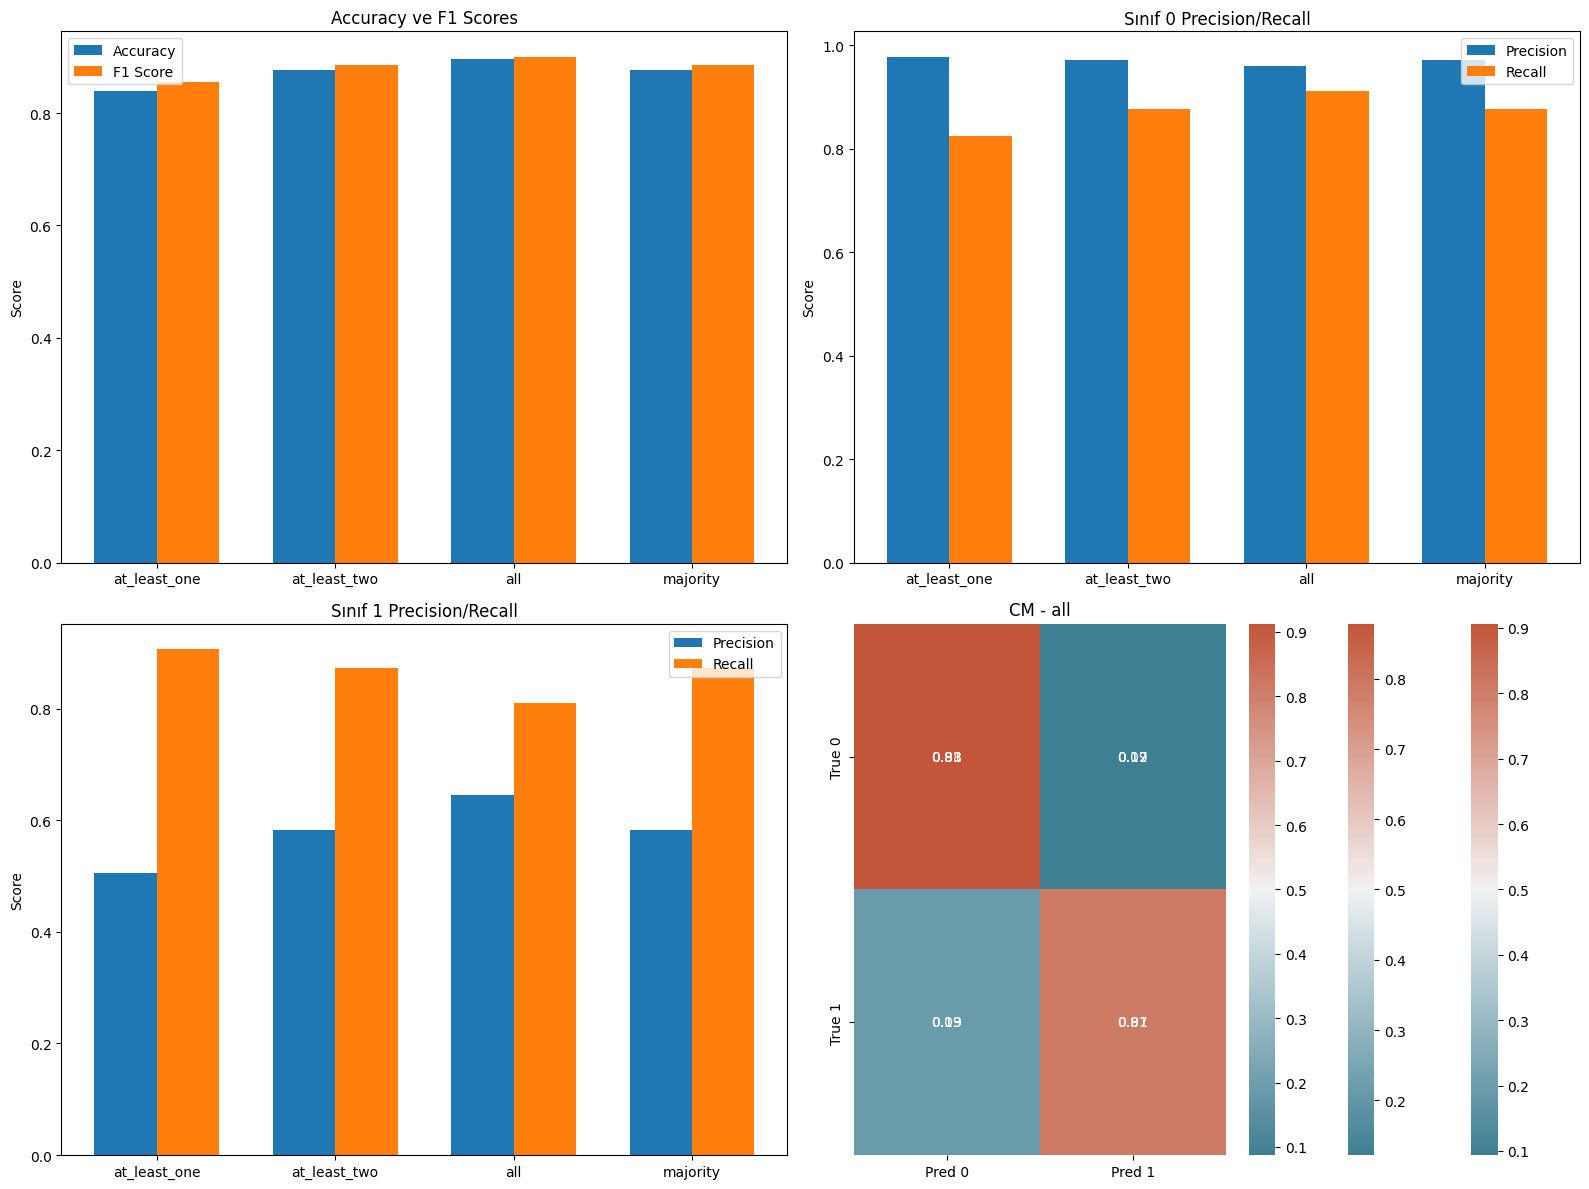

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Model yükleme fonksiyonu
def load_model(model_class, weights_path, device):
    """Eğitilmiş bir modeli yükler"""
    model = model_class().to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    return model

# Tek bir model için tahmin yapma
def predict(model, dataloader, device):
    """Bir model için tüm test seti üzerinde tahminler yapar"""
    model.eval()
    all_preds = []
    all_probs = []  # Sınıf olasılıkları

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_probs)

# Farklı voting stratejilerini değerlendirme
def evaluate_ensemble_strategies(model_preds, true_labels):
    """
    Farklı ensemble stratejilerini değerlendirir:
    1. En az 1 model sınıf 1 derse
    2. En az 2 model sınıf 1 derse
    3. Tüm modeller sınıf 1 derse
    """
    results = {}
    ensemble_preds = {}

    # Tüm tahminleri numpy array'e çevir
    model_preds_array = np.array(model_preds)

    # Strateji 1: En az 1 model sınıf 1 derse
    preds_at_least_one = (np.sum(model_preds_array == 1, axis=0) >= 1).astype(int)
    ensemble_preds['at_least_one'] = preds_at_least_one
    results['at_least_one'] = {
        'accuracy': accuracy_score(true_labels, preds_at_least_one),
        'f1': f1_score(true_labels, preds_at_least_one, average='weighted'),
        'report': classification_report(true_labels, preds_at_least_one, output_dict=True),
        'confusion': confusion_matrix(true_labels, preds_at_least_one)
    }

    # Strateji 2: En az 2 model sınıf 1 derse
    preds_at_least_two = (np.sum(model_preds_array == 1, axis=0) >= 2).astype(int)
    ensemble_preds['at_least_two'] = preds_at_least_two
    results['at_least_two'] = {
        'accuracy': accuracy_score(true_labels, preds_at_least_two),
        'f1': f1_score(true_labels, preds_at_least_two, average='weighted'),
        'report': classification_report(true_labels, preds_at_least_two, output_dict=True),
        'confusion': confusion_matrix(true_labels, preds_at_least_two)
    }

    # Strateji 3: Tüm modeller sınıf 1 derse
    preds_all = (np.sum(model_preds_array == 1, axis=0) == len(model_preds)).astype(int)
    ensemble_preds['all'] = preds_all
    results['all'] = {
        'accuracy': accuracy_score(true_labels, preds_all),
        'f1': f1_score(true_labels, preds_all, average='weighted'),
        'report': classification_report(true_labels, preds_all, output_dict=True),
        'confusion': confusion_matrix(true_labels, preds_all)
    }

    # Çoğunluk oylaması (bonus)
    preds_majority = (np.sum(model_preds_array == 1, axis=0) > len(model_preds) / 2).astype(int)
    ensemble_preds['majority'] = preds_majority
    results['majority'] = {
        'accuracy': accuracy_score(true_labels, preds_majority),
        'f1': f1_score(true_labels, preds_majority, average='weighted'),
        'report': classification_report(true_labels, preds_majority, output_dict=True),
        'confusion': confusion_matrix(true_labels, preds_majority)
    }

    return results, ensemble_preds

# Sonuçları görselleştirme
def plot_results(results):
    """Farklı stratejilerin sonuçlarını görselleştirir"""
    strategies = list(results.keys())
    accuracies = [results[s]['accuracy'] for s in strategies]
    f1_scores = [results[s]['f1'] for s in strategies]

    # Sınıf 0 ve Sınıf 1 precision, recall değerleri
    class0_precision = [results[s]['report']['0']['precision'] for s in strategies]
    class0_recall = [results[s]['report']['0']['recall'] for s in strategies]
    class1_precision = [results[s]['report']['1']['precision'] for s in strategies]
    class1_recall = [results[s]['report']['1']['recall'] for s in strategies]

    # Görselleştirme
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy ve F1
    x = np.arange(len(strategies))
    width = 0.35
    axs[0, 0].bar(x - width/2, accuracies, width, label='Accuracy')
    axs[0, 0].bar(x + width/2, f1_scores, width, label='F1 Score')
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(strategies)
    axs[0, 0].set_ylabel('Score')
    axs[0, 0].set_title('Accuracy ve F1 Scores')
    axs[0, 0].legend()

    # Sınıf 0 Precision/Recall
    axs[0, 1].bar(x - width/2, class0_precision, width, label='Precision')
    axs[0, 1].bar(x + width/2, class0_recall, width, label='Recall')
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(strategies)
    axs[0, 1].set_ylabel('Score')
    axs[0, 1].set_title('Sınıf 0 Precision/Recall')
    axs[0, 1].legend()

    # Sınıf 1 Precision/Recall
    axs[1, 0].bar(x - width/2, class1_precision, width, label='Precision')
    axs[1, 0].bar(x + width/2, class1_recall, width, label='Recall')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(strategies)
    axs[1, 0].set_ylabel('Score')
    axs[1, 0].set_title('Sınıf 1 Precision/Recall')
    axs[1, 0].legend()

    # Confusion Matrix Comparison
    confusion_data = []
    labels = []
    for strategy in strategies:
        cm = results[strategy]['confusion']
        # Normalize
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        confusion_data.append(cm)
        labels.append(strategy)

    # Confusion Matrix Heatmap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    for i, (cm, label) in enumerate(zip(confusion_data, labels)):
        row, col = 1, 1
        if i < 3:
            sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap,
                        xticklabels=['Pred 0', 'Pred 1'],
                        yticklabels=['True 0', 'True 1'],
                        ax=axs[row, col])
            axs[row, col].set_title(f'CM - {label}')
            row = 2 if col == 1 else row
            col = 0 if col == 1 else 1

    plt.tight_layout()
    plt.savefig('ensemble_comparison.png')
    plt.show()

    return fig

# Ana fonksiyon
def run_ensemble_evaluation(model_classes, model_paths, test_dataloader, device):
    """
    Verilen modelleri yükler, tahminler yapar ve farklı ensemble stratejilerini değerlendirir

    Args:
        model_classes: Model sınıflarının listesi
        model_paths: Her bir model için ağırlık dosyasının yolu
        test_dataloader: Test verisi için DataLoader
        device: Kullanılacak cihaz (cuda/cpu)
    """
    # Gerçek etiketleri topla
    true_labels = []
    for batch in test_dataloader:
        true_labels.extend(batch['labels'].numpy())
    true_labels = np.array(true_labels)

    # Her bir modeli yükle ve tahminleri yap
    all_model_preds = []
    all_model_probs = []

    for i, (model_class, model_path) in enumerate(zip(model_classes, model_paths)):
        print(f"Model {i+1} yükleniyor: {model_path}")
        model = load_model(model_class, model_path, device)
        preds, probs = predict(model, test_dataloader, device)
        all_model_preds.append(preds)
        all_model_probs.append(probs)

        # Her modelin tek başına performansını değerlendir
        print(f"Model {i+1} performansı:")
        print(f"Accuracy: {accuracy_score(true_labels, preds):.4f}")
        print(f"F1 Score: {f1_score(true_labels, preds, average='weighted'):.4f}")
        print(classification_report(true_labels, preds))
        print("-" * 50)

    # Farklı ensemble stratejilerini değerlendir
    print("Ensemble stratejileri değerlendiriliyor...")
    results, ensemble_preds = evaluate_ensemble_strategies(all_model_preds, true_labels)

    # Sonuçları yazdır
    for strategy, metrics in results.items():
        print(f"\nStrateji: {strategy}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        print(classification_report(true_labels, ensemble_preds[strategy]))
        print("Confusion Matrix:")
        print(metrics['confusion'])
        print("-" * 50)

    # Sonuçları görselleştir
    plot_results(results)

    return results, ensemble_preds




# Model sınıfları ve ağırlık yolları
model_classes = [BERTurkBiGRUEnsemble, BERTClassifier, BERTurkMLPEnsemble]
model_paths = [
    "./drive/MyDrive/TezDosyaları/best_berturk_bigru.pt",
    "./drive/MyDrive/TezDosyaları/best_berturk.pt",
    "./drive/MyDrive/TezDosyaları/best_berturk_mlp_ensemble.pt"
]

# Cihaz


# Test dataloader'ı - sizin kendi test veri yükleme kodunuzu buraya eklemeniz gerekecek
# test_dataloader = ...

# Ensemble değerlendirmesini çalıştır
results, ensemble_preds = run_ensemble_evaluation(model_classes, model_paths, test_dataloader, device)

Kullanılan cihaz: cuda
TF-IDF özellik boyutu: (35530, 5000)
2D CNN modelini kullanıyoruz...
Epoch 1/100
Train Loss: 0.7291, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7223, Val F1: 0.0455, Val Class 1 F1: 0.2796
Epoch 2/100
Train Loss: 0.7265, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7201, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7234, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7159, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 2 out of 10
Epoch 4/100
Train Loss: 0.7166, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7058, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 3 out of 10
Epoch 5/100
Train Loss: 0.7020, Train F1: 0.0467, Train Class 1 F1: 0.2798
Val Loss: 0.6952, Val F1: 0.0466, Val Class 1 F1: 0.2796
EarlyStopping counter: 4 out of 10
Epoch 6/100
Train Loss: 0.6896, Train F1: 0.0716, Train Class 1 F1: 0.2821
Val Loss: 0.6861, Val F1: 0.0875,

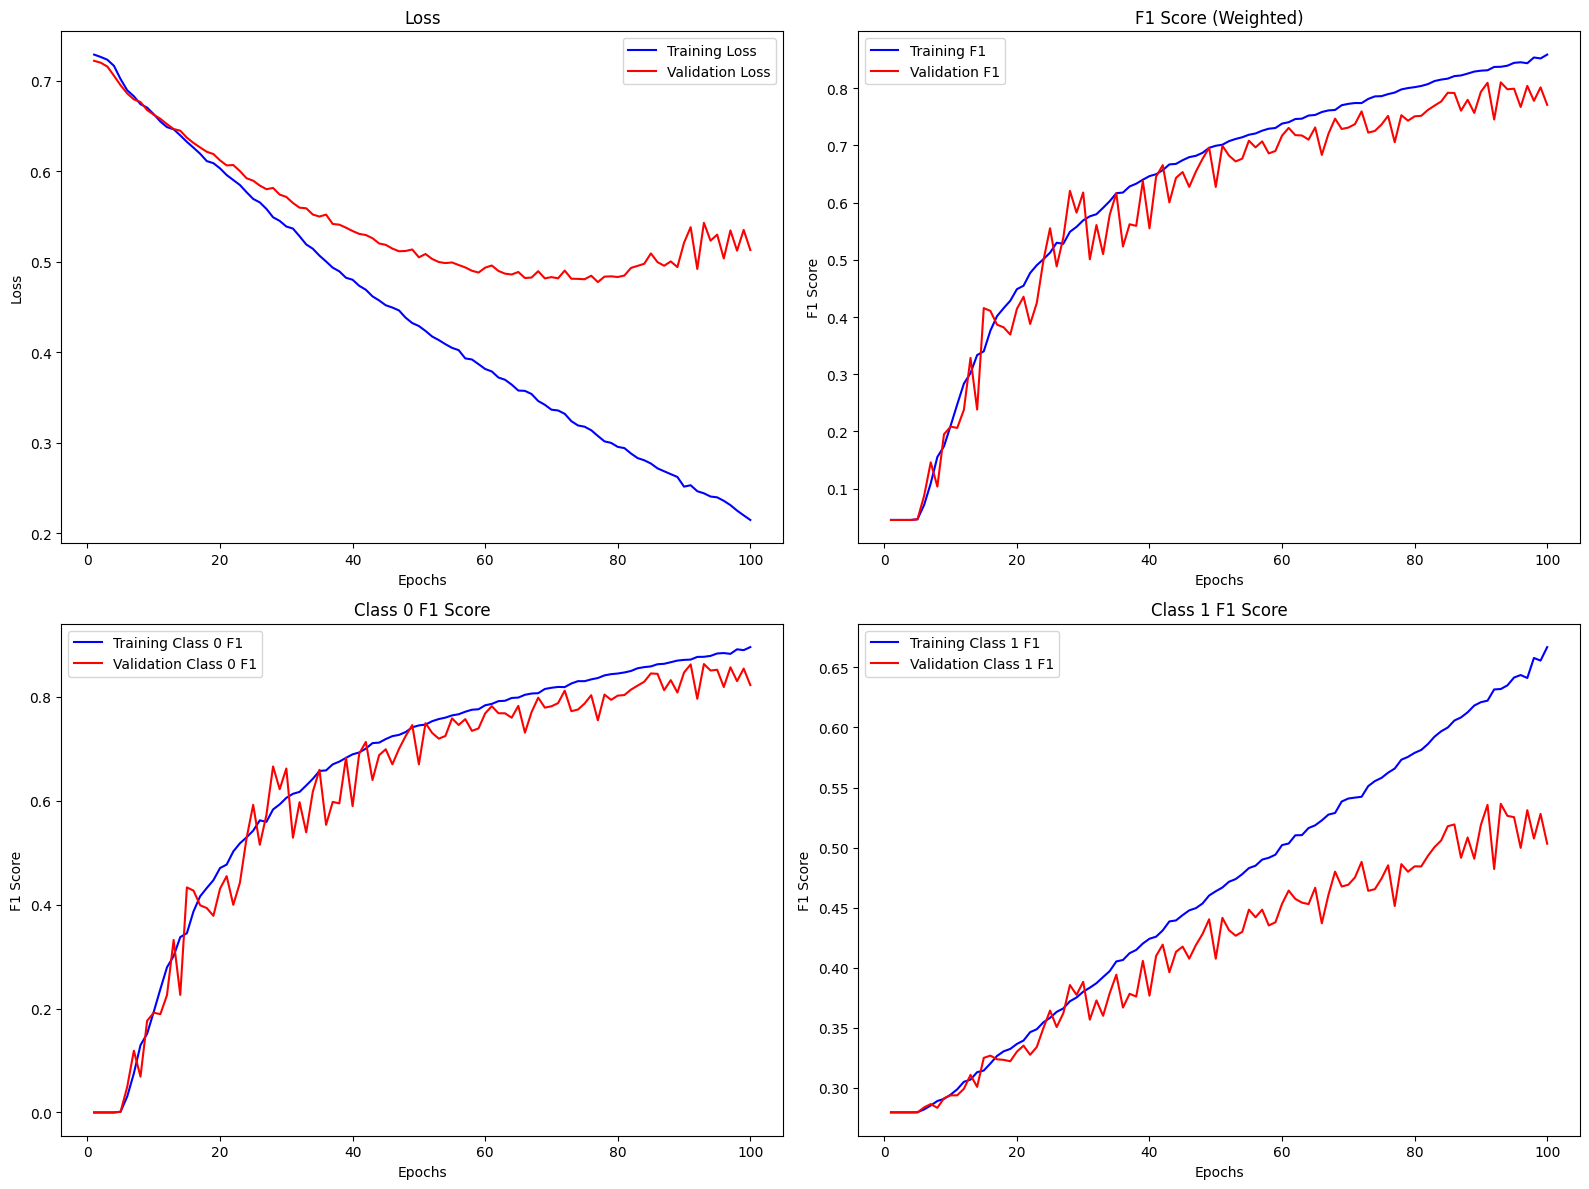

Evaluation Results:
Accuracy: 0.7876
F1 Score (Weighted): 0.8092
F1 Score for Class 1: 0.5355
Confusion Matrix:
[[4727, 1224], [285, 870]]

Test Metrics:
Overall F1 score: 0.8092
Class 1 F1 score: 0.5355
Accuracy: 0.7876
Confusion Matrix:
[[4727, 1224], [285, 870]]

Model ağırlıkları 'best_tfidf_cnn_2d.pt' dosyasına kaydedildi.
TF-IDF vektörleştirici 'tfidf_vectorizer.pkl' dosyasına kaydedildi.
Model bilgileri 'tfidf_cnn_2d_info.pkl' dosyasına kaydedildi.


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import copy
import math
import joblib

# Cuda kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Sabit değerler
BATCH_SIZE = 96
EPOCHS = 5
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_FEATURES = 5000  # TF-IDF için maksimum özellik sayısı
EMBEDDING_DIM = 64   # TF-IDF vektörlerinin projection boyutu

class TFIDFCNNEnsemble2D(nn.Module):
    def __init__(self, input_size, dropout_rate=DROPOUT_RATE):
        super(TFIDFCNNEnsemble2D, self).__init__()

        # TF-IDF vektörünü bir matrise çeviriyoruz
        self.side1 = int(math.sqrt(input_size))
        self.side2 = input_size // self.side1

        # 2D Evrişim katmanları
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Dropout katmanı
        self.dropout = nn.Dropout(dropout_rate)

        # Son sınıflandırıcı katman (3 CNN çıktısının birleştirilmiş boyutu: 128 * 3)
        self.classifier = nn.Linear(128 * 3, 2)  # Binary sınıflandırma

    def forward(self, tfidf_features):
        # TF-IDF özelliklerini embedding boyutuna projeksiyon yap
        x = self.projection(tfidf_features)  # [batch_size, input_size] -> [batch_size, embedding_dim]

        # x'i 1D CNN'ler için uygun şekle getir [batch_size, embedding_dim, sequence_length]
        # TF-IDF özellikleri aslında bir sequence değil, ama bir sequence olarak davranabiliriz
        # Burada sequence_length=1 olacak şekilde reshape ediyoruz
        x = x.unsqueeze(2)  # [batch_size, embedding_dim, 1]

        # Eğer daha uzun bir sequence istiyorsak, TF-IDF'i parçalara bölebiliriz
        # Örnek: x vektörünü 64 parçaya böl (isteğe bağlı)
        batch_size = x.size(0)
        chunk_size = max(1, embedding_dim // 64)
        # x = x.view(batch_size, chunk_size, -1)  # [batch_size, chunk_size, embedding_dim/chunk_size]
        # x = x.permute(0, 2, 1)  # [batch_size, embedding_dim/chunk_size, chunk_size]

        # Evrişim katmanlarını uygula
        conv1_out = F.relu(self.conv1(x))
        conv2_out = F.relu(self.conv2(x))
        conv3_out = F.relu(self.conv3(x))

        # Global max pooling uygula
        # Her bir özellik haritasının en belirgin özelliğini seç
        pooled_1 = F.adaptive_max_pool1d(conv1_out, 1).squeeze(2)
        pooled_2 = F.adaptive_max_pool1d(conv2_out, 1).squeeze(2)
        pooled_3 = F.adaptive_max_pool1d(conv3_out, 1).squeeze(2)

        # Tüm özellikleri birleştir
        cat = torch.cat((pooled_1, pooled_2, pooled_3), dim=1)

        # Dropout uygula
        cat = self.dropout(cat)

        # Sınıflandırma
        logits = self.classifier(cat)

        return logits

class TFIDFCNNEnsemble2D(nn.Module):
    """
    TF-IDF özellikleri için 2D CNN kullanarak daha efektif bir model.
    TF-IDF vektörlerini 2 boyutlu matrise yeniden şekillendirir.
    """
    def __init__(self, input_size, dropout_rate=DROPOUT_RATE):
        super(TFIDFCNNEnsemble2D, self).__init__()

        # TF-IDF vektörünü bir matrise çeviriyoruz
        # Örneğin 5000 -> 70x72 (yaklaşık kare matris olacak şekilde)
        self.side1 = int(math.sqrt(input_size))
        self.side2 = input_size // self.side1
        if self.side1 * self.side2 < input_size:
            self.side2 += 1

        # 2D Evrişim katmanları
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Hesaplanan final boyut
        # Başlangıç: [side1, side2]
        # 3 pooling sonrası: [side1/8, side2/8]
        self.fc_input_size = 128 * max(1, self.side1 // 8) * max(1, self.side2 // 8)

        # Fully connected katmanlar
        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, 2)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, tfidf_features):
        batch_size = tfidf_features.size(0)

        # TF-IDF vektörünü 2D matrise yeniden şekillendir
        # Padding ekle
        padded_size = self.side1 * self.side2
        if tfidf_features.size(1) < padded_size:
            padding = torch.zeros(batch_size, padded_size - tfidf_features.size(1), device=tfidf_features.device)
            x = torch.cat([tfidf_features, padding], dim=1)
        else:
            x = tfidf_features[:, :padded_size]

        # 2D tensöre yeniden şekillendir: [batch_size, 1, side1, side2]
        x = x.view(batch_size, 1, self.side1, self.side2)

        # Konvolüsyon ve pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten
        x = x.view(batch_size, -1)

        # Fully connected katmanlar
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

class CustomTFIDFDataset(Dataset):
    def __init__(self, tfidf_features, labels=None):
        self.tfidf_features = tfidf_features
        self.labels = labels

    def __len__(self):
        return len(self.tfidf_features)

    def __getitem__(self, idx):
        item = {
            'tfidf_features': torch.tensor(self.tfidf_features[idx], dtype=torch.float)
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight factor for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = nn.functional.log_softmax(inputs, dim=1)
        ce_loss = nn.functional.nll_loss(log_softmax, targets, weight=self.alpha, reduction='none')

        # Get the probabilities for the target class
        p_t = torch.exp(-ce_loss)

        # Apply the focusing term
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EarlyStoppingWithClassF1:
    def __init__(self, patience=5, min_delta=0.001, class_index=1, class_weight=0.5):
        """
        Early stopping that monitors both overall F1 and Class 1 F1 scores

        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change in monitored metrics to qualify as improvement
            class_index: Index of the class to monitor (1 for Class 1)
            class_weight: Weight given to class F1 vs overall F1 (0.5 means equal weight)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.class_index = class_index
        self.class_weight = class_weight
        self.counter = 0
        self.best_score = None
        self.best_class_f1 = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, model, val_overall_f1, val_class_f1s):
        """
        Args:
            model: Model to save if improvement
            val_overall_f1: Overall validation F1 score
            val_class_f1s: F1 scores for each class (list or array)
        """
        # Get the F1 score for the specific class we're monitoring
        class_f1 = val_class_f1s[self.class_index]

        # Calculate a combined score that considers both overall F1 and class F1
        combined_score = (1 - self.class_weight) * val_overall_f1 + self.class_weight * class_f1

        if self.best_score is None or self.best_class_f1 is None:
            # First epoch
            self.best_score = combined_score
            self.best_class_f1 = class_f1
            self.save_checkpoint(model)
        elif combined_score < self.best_score + self.min_delta:
            # Score didn't improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Score improved, but also check if Class 1 F1 didn't decrease significantly
            class_f1_decrease = self.best_class_f1 - class_f1

            # Only consider it an improvement if Class 1 F1 didn't drop too much
            if class_f1_decrease <= self.min_delta:
                print(f'Validation score improved! Overall F1: {val_overall_f1:.4f}, Class 1 F1: {class_f1:.4f}')
                self.best_score = combined_score
                self.best_class_f1 = class_f1
                self.save_checkpoint(model)
                self.counter = 0
            else:
                # Class 1 F1 dropped too much, don't reset counter
                print(f'Overall score improved but Class 1 F1 dropped too much (from {self.best_class_f1:.4f} to {class_f1:.4f})')
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        """Save model weights when validation performance improves"""
        self.best_weights = copy.deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        """Restore model to best weights"""
        model.load_state_dict(self.best_weights)

def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                num_epochs=10, patience=3, class_f1_weight=0.6, learning_rate=2e-5):
    """
    Train model with Focal Loss and balanced early stopping

    Args:
        model: Model to train
        train_dataloader: Training data loader
        test_dataloader: Validation/test data loader
        class_weights: Dictionary mapping class indices to weights (e.g., {0: 1, 1: 6})
        gamma: Focal loss focusing parameter
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience
        class_f1_weight: Weight to give to Class 1 F1 score in early stopping
        learning_rate: Learning rate for optimizer

    Returns:
        trained_model: The trained model
        history: Dictionary containing training metrics
    """
    # Set up device
    device = next(model.parameters()).device

    # Create alpha tensor for focal loss based on class weights
    if class_weights is not None:
        num_classes = len(class_weights)
        alpha = torch.ones(num_classes)
        for cls_idx, weight in class_weights.items():
            alpha[cls_idx] = weight
        alpha = alpha.to(device)
    else:
        alpha = None

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up early stopping
    early_stopping = EarlyStoppingWithClassF1(
        patience=patience,
        class_index=1,  # Monitor Class 1 F1
        class_weight=class_f1_weight
    )

    # Track metrics
    history = {
        'train_loss': [],
        'train_f1': [],
        'train_class_f1s': [],
        'val_loss': [],
        'val_f1': [],
        'val_class_f1s': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in train_dataloader:
            tfidf_features = batch['tfidf_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(tfidf_features)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_class_f1s = f1_score(train_labels, train_preds, average=None)

        # Save training metrics
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_class_f1s'].append(train_class_f1s.tolist())

        # Validation phase
        if test_dataloader is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for batch in test_dataloader:
                    tfidf_features = batch['tfidf_features'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(tfidf_features)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss = val_loss / len(test_dataloader)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_class_f1s = f1_score(val_labels, val_preds, average=None)

            # Save validation metrics
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_class_f1s'].append(val_class_f1s.tolist())

            # Print epoch results
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Class 1 F1: {val_class_f1s[1]:.4f}')

            # Early stopping check
            early_stopping(model, val_f1, val_class_f1s)

            if early_stopping.early_stop:
                print("Early stopping triggered")
                # Restore best weights
                early_stopping.restore_best_weights(model)
                break
        else:
            # Print training metrics when no validation set provided
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')

    # Load best weights if early stopping was used
    if test_dataloader is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)

    return model, history

def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model performance

    Args:
        model: Trained model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            tfidf_features = batch['tfidf_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(tfidf_features)

            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_by_class': f1_score(all_labels, all_preds, average=None),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds).tolist(),
        'classification_report': classification_report(all_labels, all_preds, output_dict=True)
    }

    # Add loss if criterion was provided
    if criterion is not None:
        metrics['loss'] = total_loss / len(dataloader)

    # Print key metrics
    print(f"Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score for Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics

def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer val_loss yoksa, sadece train metriklerini çizdir
    has_val = "val_loss" in history and len(history["val_loss"]) > 0

    # Loss grafiği
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_val:
        plt.plot(epochs, history["val_loss"], 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_val:
        plt.plot(epochs, history["val_f1"], 'r-', label='Validation F1')
    plt.title('F1 Score (Weighted)')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 0
    plt.subplot(2, 2, 3)
    train_class_0_f1 = [f1s[0] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_0_f1, 'b-', label='Training Class 0 F1')
    if has_val:
        val_class_0_f1 = [f1s[0] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_0_f1, 'r-', label='Validation Class 0 F1')
    plt.title('Class 0 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 1
    plt.subplot(2, 2, 4)
    train_class_1_f1 = [f1s[1] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_1_f1, 'b-', label='Training Class 1 F1')
    if has_val:
        val_class_1_f1 = [f1s[1] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_1_f1, 'r-', label='Validation Class 1 F1')
    plt.title('Class 1 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('tfidf_cnn_training_history.png')
    plt.show()


# Veriyi yükle
df = pd.read_csv('dataset.csv')
texts = df["text"].values.tolist()
labels = df["label"].values.tolist()

# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),  # Unigram ve bigram
    lowercase=True,
    max_df=0.95,  # Çok yaygın kelimeleri filtrele
    min_df=2      # Çok nadir kelimeleri filtrele
)

# TF-IDF özelliklerini oluştur
tfidf_features = tfidf_vectorizer.fit_transform(texts).toarray()
print(f"TF-IDF özellik boyutu: {tfidf_features.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Dataset ve DataLoader oluşturma
train_dataset = CustomTFIDFDataset(X_train, y_train)
test_dataset = CustomTFIDFDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Hangi modeli kullanacağımızı seçelim
use_2d_cnn = True  # True: 2D CNN, False: 1D CNN

if use_2d_cnn:
    print("2D CNN modelini kullanıyoruz...")
    model = TFIDFCNNEnsemble2D(input_size=MAX_FEATURES, dropout_rate=DROPOUT_RATE).to(DEVICE)
    model_name = "tfidf_cnn_2d"
else:
    print("1D CNN modelini kullanıyoruz...")
    model = TFIDFCNNEnsemble(input_size=MAX_FEATURES, embedding_dim=EMBEDDING_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
    model_name = "tfidf_cnn_1d"

# Sınıf ağırlığı ve Focal Loss parametreleri
class_weights = {0: 1, 1: 6}  # Sınıf dengesizliğine göre
gamma = 2.0  # Focal Loss focusing parametresi

# Modeli eğitme
trained_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    class_weights=class_weights,
    gamma=gamma,
    num_epochs=100,
    patience=10,
    class_f1_weight=0.6,
    learning_rate=LEARNING_RATE
)

# Eğitim grafiklerini çizdir
plot_training_history(history)

# Son test değerlendirmesi
focal_loss = FocalLoss(
    alpha=torch.tensor([1, 6]).float().to(DEVICE),
    gamma=gamma
)
test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)

# Sonuçları görüntüleme
print(f"\nTest Metrics:")
print(f"Overall F1 score: {test_metrics['f1_weighted']:.4f}")
print(f"Class 1 F1 score: {test_metrics['f1_by_class'][1]:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Confusion Matrix:")
print(test_metrics['confusion_matrix'])

# Model ağırlıklarını kaydet
torch.save(trained_model.state_dict(), f'best_{model_name}.pt')

# TF-IDF vektörleştiriciyi de kaydet
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print(f"\nModel ağırlıkları 'best_{model_name}.pt' dosyasına kaydedildi.")
print("TF-IDF vektörleştirici 'tfidf_vectorizer.pkl' dosyasına kaydedildi.")

# Model mimarisini de ayrıca kaydet
# Böylece model yüklenirken doğru mimariye sahip model oluşturulabilir
model_info = {
    'model_type': '2d_cnn' if use_2d_cnn else '1d_cnn',
    'input_size': MAX_FEATURES,
    'embedding_dim': EMBEDDING_DIM,
    'dropout_rate': DROPOUT_RATE,
    'test_metrics': test_metrics
}
joblib.dump(model_info, f'{model_name}_info.pkl')
print(f"Model bilgileri '{model_name}_info.pkl' dosyasına kaydedildi.")


Kullanılan cihaz: cuda
Dataset size: 35530
Label distribution: Counter({0: 29755, 1: 5775})
Vocabulary size: 60179
Sequences shape: (35530, 100)

Training with FASTTEXT embeddings and 2D CNN
Loading embeddings from embedded_fasttext.npy
Embeddings shape: (35225, 100)
2D CNN modelini kullanıyoruz with fasttext...
Total parameters: 32,696,134
Trainable parameters: 32,696,134
Epoch 1/100
Train Loss: 0.7233, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7097, Val F1: 0.0455, Val Class 1 F1: 0.2796
Epoch 2/100
Train Loss: 0.7161, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7082, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7147, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7055, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 2 out of 10
Epoch 4/100
Train Loss: 0.7136, Train F1: 0.0456, Train Class 1 F1: 0.2795
Val Loss: 0.7021, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 3 o

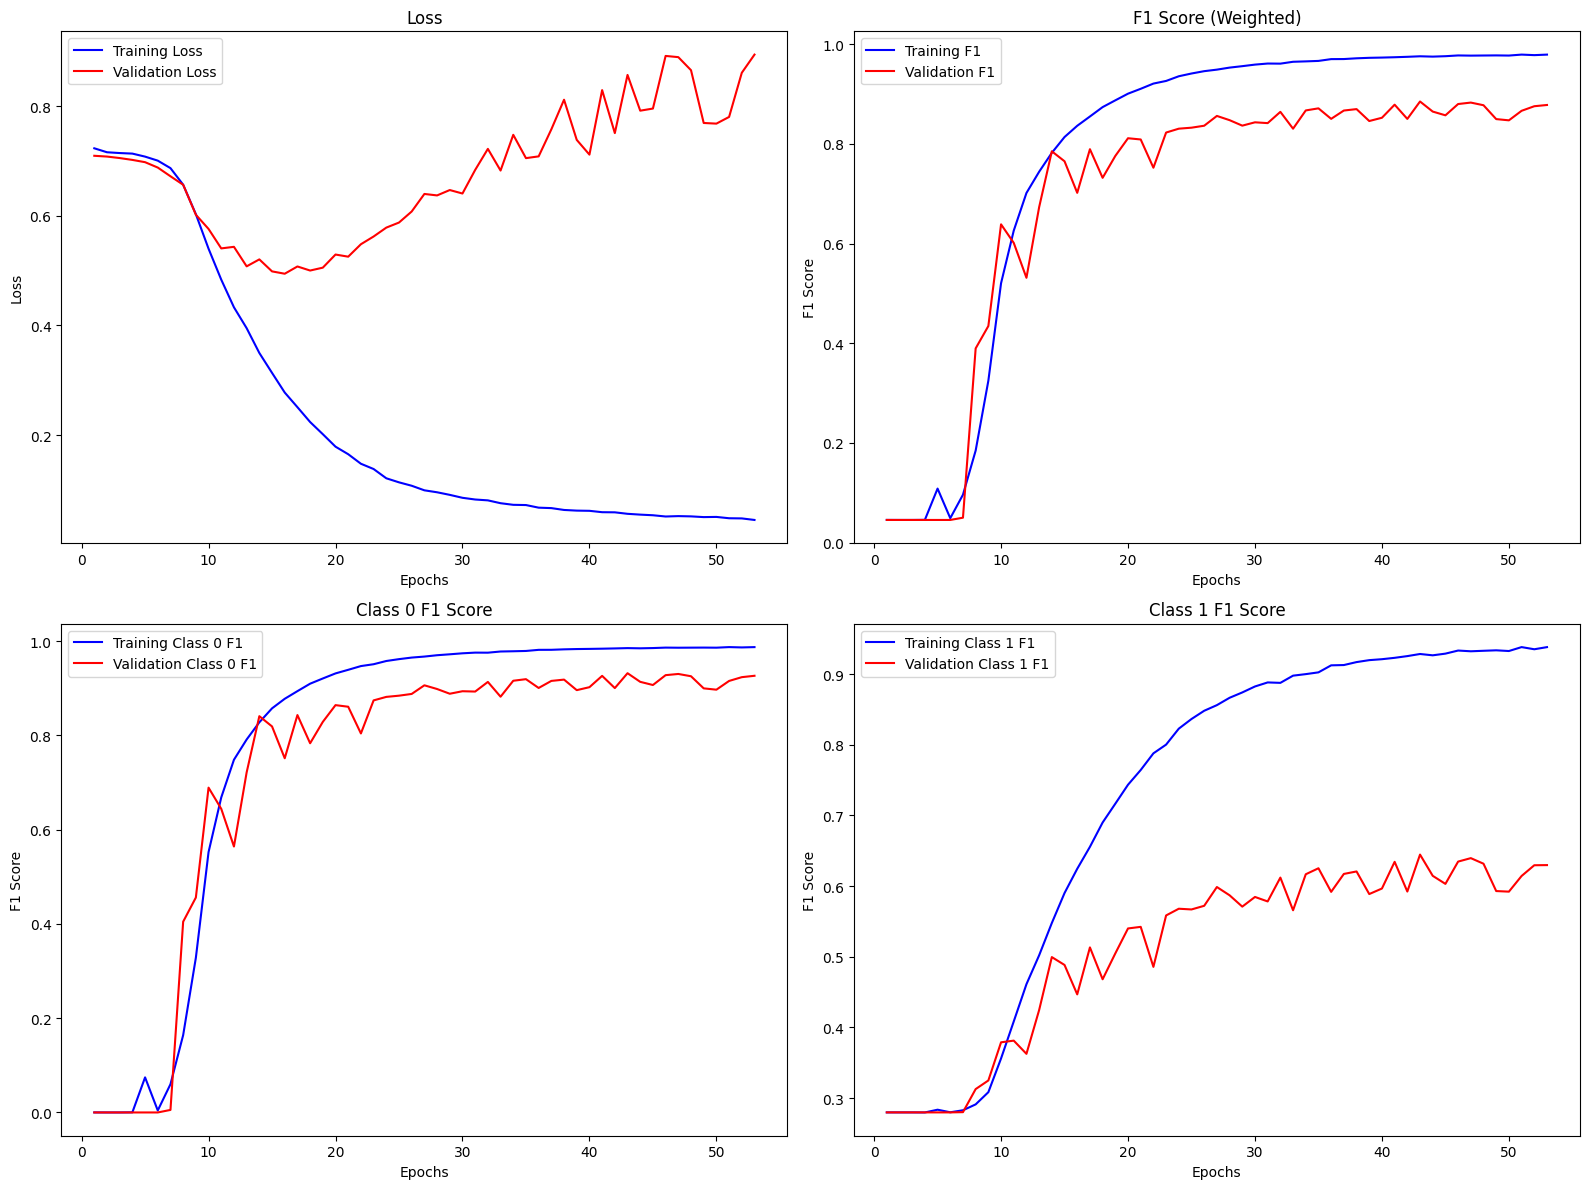

Evaluation Results:
Accuracy: 0.8856
F1 Score (Weighted): 0.8851
F1 Score for Class 1: 0.6445
Confusion Matrix:
[[5556, 395], [418, 737]]

FASTTEXT 2D-CNN Test Results:
Overall F1 score: 0.8851
Class 1 F1 score: 0.6445
Accuracy: 0.8856
Confusion Matrix:
[[5556, 395], [418, 737]]

Model ağırlıkları 'best_fasttext_cnn_2d.pt' dosyasına kaydedildi.
Model bilgileri 'fasttext_cnn_2d_info.pkl' dosyasına kaydedildi.

Training with WORD2VEC embeddings and 2D CNN
Loading embeddings from embedded_w2v.npy
Embeddings shape: (35225, 100)
2D CNN modelini kullanıyoruz with word2vec...
Total parameters: 32,696,134
Trainable parameters: 32,696,134
Epoch 1/100
Train Loss: 0.7212, Train F1: 0.0506, Train Class 1 F1: 0.2791
Val Loss: 0.7067, Val F1: 0.0455, Val Class 1 F1: 0.2796
Epoch 2/100
Train Loss: 0.7179, Train F1: 0.0502, Train Class 1 F1: 0.2797
Val Loss: 0.7062, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7132, Train F1: 0.0508, Train Class 1

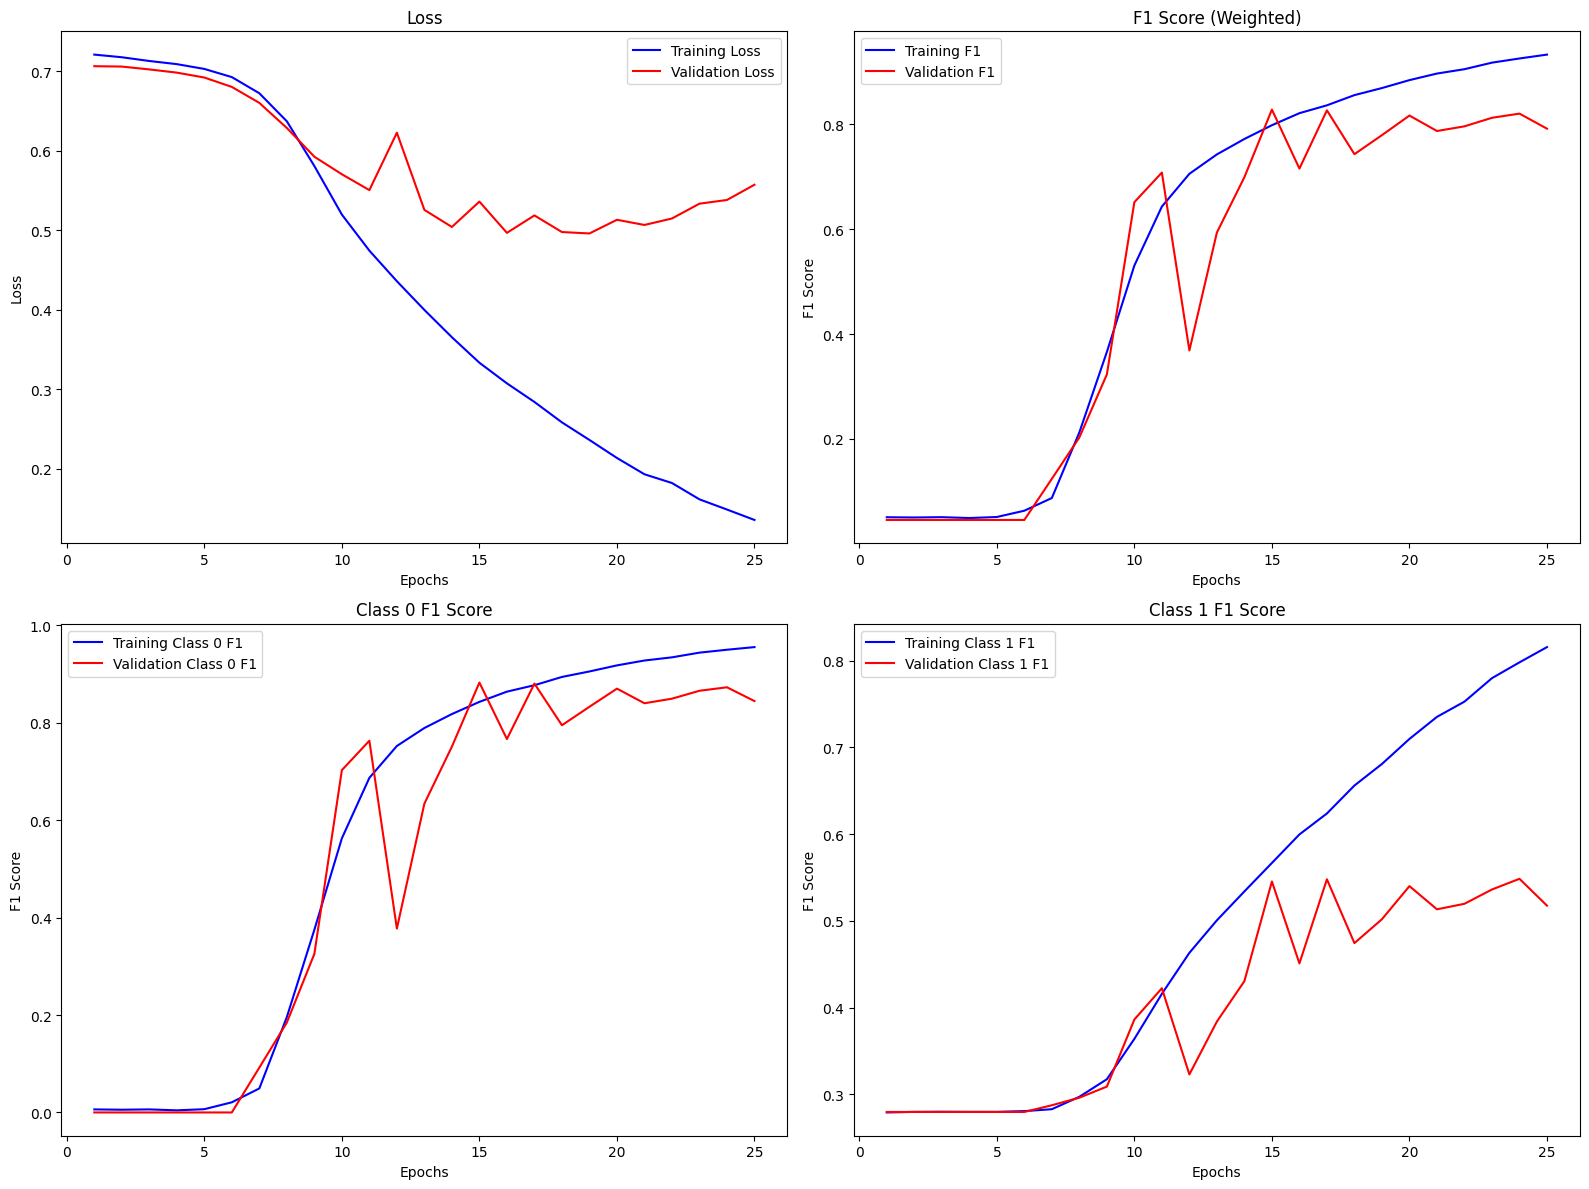

Evaluation Results:
Accuracy: 0.8137
F1 Score (Weighted): 0.8280
F1 Score for Class 1: 0.5453
Confusion Matrix:
[[4988, 963], [361, 794]]

WORD2VEC 2D-CNN Test Results:
Overall F1 score: 0.8280
Class 1 F1 score: 0.5453
Accuracy: 0.8137
Confusion Matrix:
[[4988, 963], [361, 794]]

Model ağırlıkları 'best_word2vec_cnn_2d.pt' dosyasına kaydedildi.
Model bilgileri 'word2vec_cnn_2d_info.pkl' dosyasına kaydedildi.

Training completed for all embedding types and CNN architectures!


In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import copy
import math
import joblib
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
# İlk çalıştırmada gerekli
# nltk.download('punkt')

# Cuda kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Sabit değerler
BATCH_SIZE = 96
EPOCHS = 5
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_SEQ_LENGTH = 100  # Maksimum sequence uzunluğu
EMBEDDING_DIM = 300   # FastText/Word2Vec embedding boyutu

class TextPreprocessor:
    def __init__(self, max_seq_length=MAX_SEQ_LENGTH):
        self.max_seq_length = max_seq_length
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2

    def clean_text(self, text):
        """Metni temizle"""
        text = text.lower()
        text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞIÖÇ\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize_text(self, text):
        """Metni tokenize et"""
        try:
            tokens = word_tokenize(text)
        except:
            # Eğer nltk tokenizer çalışmazsa basit split kullan
            tokens = text.split()
        return tokens

    def build_vocab_from_texts(self, texts):
        """Metinlerden vocabulary oluştur"""
        word_count = Counter()

        for text in texts:
            cleaned_text = self.clean_text(text)
            tokens = self.tokenize_text(cleaned_text)
            word_count.update(tokens)

        # Sadece 2'den fazla geçen kelimeleri al
        for word, count in word_count.items():
            if count >= 2 and word not in self.word_to_idx:
                self.word_to_idx[word] = self.vocab_size
                self.idx_to_word[self.vocab_size] = word
                self.vocab_size += 1

        print(f"Vocabulary size: {self.vocab_size}")

    def text_to_sequence(self, text):
        """Metni sequence'e çevir"""
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_text(cleaned_text)

        sequence = []
        for token in tokens:
            if token in self.word_to_idx:
                sequence.append(self.word_to_idx[token])
            else:
                sequence.append(self.word_to_idx['<UNK>'])

        # Padding veya truncation
        if len(sequence) > self.max_seq_length:
            sequence = sequence[:self.max_seq_length]
        else:
            sequence.extend([self.word_to_idx['<PAD>']] * (self.max_seq_length - len(sequence)))

        return sequence

    def texts_to_sequences(self, texts):
        """Birden fazla metni sequence'e çevir"""
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return np.array(sequences)

class EmbeddingLoader:
    def __init__(self, embedding_path, embedding_dim=EMBEDDING_DIM):
        self.embedding_path = embedding_path
        self.embedding_dim = embedding_dim
        self.embeddings = None

    def load_embeddings(self):
        """NPY dosyasından embeddings yükle"""
        print(f"Loading embeddings from {self.embedding_path}")
        self.embeddings = np.load(self.embedding_path)
        print(f"Embeddings shape: {self.embeddings.shape}")
        return self.embeddings

    def create_embedding_matrix(self, word_to_idx, vocab_size):
        """Vocabulary için embedding matrix oluştur"""
        if self.embeddings is None:
            self.load_embeddings()

        # Embedding matrix oluştur
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, self.embedding_dim))

        # <PAD> token için sıfır vektör
        embedding_matrix[0] = np.zeros(self.embedding_dim)

        # TODO: NPY dosyasının formatına göre embedding eşleştirmesi
        # Şu an random initialization kullanıyoruz

        return embedding_matrix.astype(np.float32)

class EmbeddingCNN1D(nn.Module):
    """
    1D CNN model for text classification using embeddings.
    Uses multiple filter sizes for better feature extraction.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix=None,
                 dropout_rate=DROPOUT_RATE, freeze_embeddings=True):
        super(EmbeddingCNN1D, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Pre-trained embeddings ile initialize et
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        # Multiple CNN layers with different kernel sizes
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, 128, kernel_size=4, padding=2)
        self.conv3 = nn.Conv1d(embedding_dim, 128, kernel_size=5, padding=2)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # Final classifier (3 CNN outputs concatenated: 128 * 3)
        self.classifier = nn.Linear(128 * 3, 2)

    def forward(self, input_ids):
        # Embedding lookup
        embedded = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]

        # Transpose for 1D conv: [batch_size, embedding_dim, seq_len]
        embedded = embedded.transpose(1, 2)

        # Apply convolutions
        conv1_out = F.relu(self.conv1(embedded))
        conv2_out = F.relu(self.conv2(embedded))
        conv3_out = F.relu(self.conv3(embedded))

        # Global max pooling - get the most important feature from each filter
        pooled_1 = F.adaptive_max_pool1d(conv1_out, 1).squeeze(2)
        pooled_2 = F.adaptive_max_pool1d(conv2_out, 1).squeeze(2)
        pooled_3 = F.adaptive_max_pool1d(conv3_out, 1).squeeze(2)

        # Concatenate all features
        cat = torch.cat((pooled_1, pooled_2, pooled_3), dim=1)

        # Apply dropout
        cat = self.dropout(cat)

        # Classification
        logits = self.classifier(cat)

        return logits

class EmbeddingCNN2D(nn.Module):
    """
    2D CNN model for text classification using embeddings.
    Treats embedded sequences as 2D images for convolution.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix=None,
                 max_seq_length=MAX_SEQ_LENGTH, dropout_rate=DROPOUT_RATE,
                 freeze_embeddings=True):
        super(EmbeddingCNN2D, self).__init__()

        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Pre-trained embeddings ile initialize et
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        # 2D Convolution layers
        # Input shape: [batch_size, 1, seq_len, embedding_dim]
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size after convolutions and pooling
        # After 3 pooling operations: seq_len/8 x embedding_dim/8
        conv_output_size = 128 * max(1, max_seq_length // 8) * max(1, embedding_dim // 8)

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.fc2 = nn.Linear(256, 2)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids):
        batch_size = input_ids.size(0)

        # Embedding lookup
        embedded = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]

        # Add channel dimension for 2D conv: [batch_size, 1, seq_len, embedding_dim]
        embedded = embedded.unsqueeze(1)

        # Apply 2D convolutions and pooling
        x = self.pool(F.relu(self.conv1(embedded)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten for fully connected layers
        x = x.view(batch_size, -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

class EmbeddingDataset(Dataset):
    def __init__(self, sequences, labels=None):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.sequences[idx], dtype=torch.long)
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight factor for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = nn.functional.log_softmax(inputs, dim=1)
        ce_loss = nn.functional.nll_loss(log_softmax, targets, weight=self.alpha, reduction='none')

        # Get the probabilities for the target class
        p_t = torch.exp(-ce_loss)

        # Apply the focusing term
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EarlyStoppingWithClassF1:
    def __init__(self, patience=5, min_delta=0.001, class_index=1, class_weight=0.5):
        """
        Early stopping that monitors both overall F1 and Class 1 F1 scores

        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change in monitored metrics to qualify as improvement
            class_index: Index of the class to monitor (1 for Class 1)
            class_weight: Weight given to class F1 vs overall F1 (0.5 means equal weight)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.class_index = class_index
        self.class_weight = class_weight
        self.counter = 0
        self.best_score = None
        self.best_class_f1 = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, model, val_overall_f1, val_class_f1s):
        """
        Args:
            model: Model to save if improvement
            val_overall_f1: Overall validation F1 score
            val_class_f1s: F1 scores for each class (list or array)
        """
        # Get the F1 score for the specific class we're monitoring
        class_f1 = val_class_f1s[self.class_index]

        # Calculate a combined score that considers both overall F1 and class F1
        combined_score = (1 - self.class_weight) * val_overall_f1 + self.class_weight * class_f1

        if self.best_score is None or self.best_class_f1 is None:
            # First epoch
            self.best_score = combined_score
            self.best_class_f1 = class_f1
            self.save_checkpoint(model)
        elif combined_score < self.best_score + self.min_delta:
            # Score didn't improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Score improved, but also check if Class 1 F1 didn't decrease significantly
            class_f1_decrease = self.best_class_f1 - class_f1

            # Only consider it an improvement if Class 1 F1 didn't drop too much
            if class_f1_decrease <= self.min_delta:
                print(f'Validation score improved! Overall F1: {val_overall_f1:.4f}, Class 1 F1: {class_f1:.4f}')
                self.best_score = combined_score
                self.best_class_f1 = class_f1
                self.save_checkpoint(model)
                self.counter = 0
            else:
                # Class 1 F1 dropped too much, don't reset counter
                print(f'Overall score improved but Class 1 F1 dropped too much (from {self.best_class_f1:.4f} to {class_f1:.4f})')
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        """Save model weights when validation performance improves"""
        self.best_weights = copy.deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        """Restore model to best weights"""
        model.load_state_dict(self.best_weights)

def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                num_epochs=10, patience=3, class_f1_weight=0.6, learning_rate=2e-5):
    """
    Train model with Focal Loss and balanced early stopping

    Args:
        model: Model to train
        train_dataloader: Training data loader
        test_dataloader: Validation/test data loader
        class_weights: Dictionary mapping class indices to weights (e.g., {0: 1, 1: 6})
        gamma: Focal loss focusing parameter
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience
        class_f1_weight: Weight to give to Class 1 F1 score in early stopping
        learning_rate: Learning rate for optimizer

    Returns:
        trained_model: The trained model
        history: Dictionary containing training metrics
    """
    # Set up device
    device = next(model.parameters()).device

    # Create alpha tensor for focal loss based on class weights
    if class_weights is not None:
        num_classes = len(class_weights)
        alpha = torch.ones(num_classes)
        for cls_idx, weight in class_weights.items():
            alpha[cls_idx] = weight
        alpha = alpha.to(device)
    else:
        alpha = None

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up early stopping
    early_stopping = EarlyStoppingWithClassF1(
        patience=patience,
        class_index=1,  # Monitor Class 1 F1
        class_weight=class_f1_weight
    )

    # Track metrics
    history = {
        'train_loss': [],
        'train_f1': [],
        'train_class_f1s': [],
        'val_loss': [],
        'val_f1': [],
        'val_class_f1s': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_class_f1s = f1_score(train_labels, train_preds, average=None)

        # Save training metrics
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_class_f1s'].append(train_class_f1s.tolist())

        # Validation phase
        if test_dataloader is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for batch in test_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(input_ids)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss = val_loss / len(test_dataloader)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_class_f1s = f1_score(val_labels, val_preds, average=None)

            # Save validation metrics
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_class_f1s'].append(val_class_f1s.tolist())

            # Print epoch results
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Class 1 F1: {val_class_f1s[1]:.4f}')

            # Early stopping check
            early_stopping(model, val_f1, val_class_f1s)

            if early_stopping.early_stop:
                print("Early stopping triggered")
                # Restore best weights
                early_stopping.restore_best_weights(model)
                break
        else:
            # Print training metrics when no validation set provided
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')

    # Load best weights if early stopping was used
    if test_dataloader is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)

    return model, history

def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model performance

    Args:
        model: Trained model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids)

            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_by_class': f1_score(all_labels, all_preds, average=None),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds).tolist(),
        'classification_report': classification_report(all_labels, all_preds, output_dict=True)
    }

    # Add loss if criterion was provided
    if criterion is not None:
        metrics['loss'] = total_loss / len(dataloader)

    # Print key metrics
    print(f"Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score for Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics

def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer val_loss yoksa, sadece train metriklerini çizdir
    has_val = "val_loss" in history and len(history["val_loss"]) > 0

    # Loss grafiği
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_val:
        plt.plot(epochs, history["val_loss"], 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_val:
        plt.plot(epochs, history["val_f1"], 'r-', label='Validation F1')
    plt.title('F1 Score (Weighted)')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 0
    plt.subplot(2, 2, 3)
    train_class_0_f1 = [f1s[0] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_0_f1, 'b-', label='Training Class 0 F1')
    if has_val:
        val_class_0_f1 = [f1s[0] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_0_f1, 'r-', label='Validation Class 0 F1')
    plt.title('Class 0 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class F1 grafiği - sınıf 1
    plt.subplot(2, 2, 4)
    train_class_1_f1 = [f1s[1] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, train_class_1_f1, 'b-', label='Training Class 1 F1')
    if has_val:
        val_class_1_f1 = [f1s[1] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, val_class_1_f1, 'r-', label='Validation Class 1 F1')
    plt.title('Class 1 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('embedding_cnn_training_history.png')
    plt.show()

# ANA KOD - FastText ve Word2Vec ile eğitim
def main():
    # Veriyi yükle
    df = pd.read_csv('dataset.csv')
    texts = df["text"].values.tolist()
    labels = df["label"].values.tolist()

    print(f"Dataset size: {len(texts)}")
    print(f"Label distribution: {Counter(labels)}")

    # Text preprocessing
    preprocessor = TextPreprocessor(max_seq_length=MAX_SEQ_LENGTH)
    preprocessor.build_vocab_from_texts(texts)

    # Metinleri sequence'lere çevir
    sequences = preprocessor.texts_to_sequences(texts)
    print(f"Sequences shape: {sequences.shape}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        sequences, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # FastText ve Word2Vec için ayrı ayrı eğitim
    embedding_types = ['fasttext', 'word2vec']
    embedding_files = {
        'fasttext': 'embedded_fasttext.npy',  # FastText .npy dosyanızın adı
        'word2vec': 'embedded_w2v.npy'   # Word2Vec .npy dosyanızın adı
    }

    # CNN model türleri
    cnn_types = ['2d']

    for embedding_type in embedding_types:
        for cnn_type in cnn_types:
            print(f"\n{'='*60}")
            print(f"Training with {embedding_type.upper()} embeddings and {cnn_type.upper()} CNN")
            print(f"{'='*60}")

            # Embeddings yükle
            embedding_loader = EmbeddingLoader(embedding_files[embedding_type])
            embedding_matrix = embedding_loader.create_embedding_matrix(
                preprocessor.word_to_idx,
                preprocessor.vocab_size
            )

            # Dataset ve DataLoader oluştur
            train_dataset = EmbeddingDataset(X_train, y_train)
            test_dataset = EmbeddingDataset(X_test, y_test)

            train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

            # Model seçimi
            if cnn_type == '1d':
                print(f"1D CNN modelini kullanıyoruz with {embedding_type}...")
                model = EmbeddingCNN1D(
                    vocab_size=preprocessor.vocab_size,
                    embedding_dim=EMBEDDING_DIM,
                    embedding_matrix=embedding_matrix,
                    dropout_rate=DROPOUT_RATE,
                    freeze_embeddings=False  # Embedding'leri fine-tune et
                ).to(DEVICE)
                model_name = f"{embedding_type}_cnn_1d"
            else:  # 2d
                print(f"2D CNN modelini kullanıyoruz with {embedding_type}...")
                model = EmbeddingCNN2D(
                    vocab_size=preprocessor.vocab_size,
                    embedding_dim=EMBEDDING_DIM,
                    embedding_matrix=embedding_matrix,
                    max_seq_length=MAX_SEQ_LENGTH,
                    dropout_rate=DROPOUT_RATE,
                    freeze_embeddings=False  # Embedding'leri fine-tune et
                ).to(DEVICE)
                model_name = f"{embedding_type}_cnn_2d"

            # Model parametrelerini göster
            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Total parameters: {total_params:,}")
            print(f"Trainable parameters: {trainable_params:,}")

            # Sınıf ağırlığı ve Focal Loss parametreleri
            class_weights = {0: 1, 1: 6}  # Sınıf dengesizliğine göre
            gamma = 2.0  # Focal Loss focusing parametresi

            # Modeli eğitme
            trained_model, history = train_model(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                class_weights=class_weights,
                gamma=gamma,
                num_epochs=100,
                patience=10,
                class_f1_weight=0.6,
                learning_rate=LEARNING_RATE
            )

            # Eğitim grafiklerini çizdir
            plot_training_history(history)

            # Son test değerlendirmesi
            focal_loss = FocalLoss(
                alpha=torch.tensor([1, 6]).float().to(DEVICE),
                gamma=gamma
            )
            test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)

            # Sonuçları görüntüleme
            print(f"\n{embedding_type.upper()} {cnn_type.upper()}-CNN Test Results:")
            print(f"Overall F1 score: {test_metrics['f1_weighted']:.4f}")
            print(f"Class 1 F1 score: {test_metrics['f1_by_class'][1]:.4f}")
            print(f"Accuracy: {test_metrics['accuracy']:.4f}")
            print(f"Confusion Matrix:")
            print(test_metrics['confusion_matrix'])

            # Model ağırlıklarını kaydet
            torch.save(trained_model.state_dict(), f'best_{model_name}.pt')

            # Model mimarisini de ayrıca kaydet
            model_info = {
                'embedding_type': embedding_type,
                'model_type': f'cnn_{cnn_type}',
                'vocab_size': preprocessor.vocab_size,
                'embedding_dim': EMBEDDING_DIM,
                'max_seq_length': MAX_SEQ_LENGTH,
                'dropout_rate': DROPOUT_RATE,
                'test_metrics': test_metrics,
                'word_to_idx': preprocessor.word_to_idx
            }
            joblib.dump(model_info, f'{model_name}_info.pkl')

            print(f"\nModel ağırlıkları 'best_{model_name}.pt' dosyasına kaydedildi.")
            print(f"Model bilgileri '{model_name}_info.pkl' dosyasına kaydedildi.")

def visualize_filters(model, sample_text, preprocessor, num_filters=8, embedding_type='fasttext'):
    """
    CNN filtrelerinin aktivasyonlarını görselleştir (sadece 1D CNN için)
    """
    if not hasattr(model, 'conv1'):
        print("Bu model CNN filtrelerine sahip değil.")
        return

    model.eval()
    device = next(model.parameters()).device

    # Sample text'i sequence'e çevir
    sequence = preprocessor.text_to_sequence(sample_text)
    input_tensor = torch.tensor([sequence], dtype=torch.long).to(device)

    with torch.no_grad():
        # Embedding al
        embedded = model.embedding(input_tensor)  # [1, seq_len, embedding_dim]
        embedded = embedded.transpose(1, 2)  # [1, embedding_dim, seq_len]

        # İlk konvolüsyon katmanının aktivasyonlarını al
        conv1_out = F.relu(model.conv1(embedded))  # [1, 128, seq_len]

        # Görselleştirme
        plt.figure(figsize=(15, 10))

        # Sample text'i göster
        plt.suptitle(f'CNN Filter Activations for: "{sample_text[:50]}..."\nEmbedding: {embedding_type.upper()}',
                     fontsize=14)

        for i in range(min(num_filters, conv1_out.size(1))):
            plt.subplot(2, 4, i+1)
            activation = conv1_out[0, i, :].cpu().numpy()
            plt.plot(activation)
            plt.title(f'Filter {i+1}')
            plt.xlabel('Sequence Position')
            plt.ylabel('Activation')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{embedding_type}_cnn_filter_activations.png', dpi=300, bbox_inches='tight')
        plt.show()

def compare_embeddings_performance(results_dict):
    """
    Farklı embedding türlerinin performanslarını karşılaştır
    """
    plt.figure(figsize=(15, 10))

    # Embedding türleri ve model tipleri
    embedding_types = ['fasttext', 'word2vec']
    model_types = ['cnn_1d', 'cnn_2d']

    metrics = ['accuracy', 'f1_weighted', 'f1_by_class']

    # Her metrik için subplot
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)

        if metric == 'f1_by_class':
            # Class 1 F1 skorunu göster
            values = []
            labels = []
            for emb_type in embedding_types:
                for model_type in model_types:
                    key = f"{emb_type}_{model_type}"
                    if key in results_dict:
                        values.append(results_dict[key]['f1_by_class'][1])
                        labels.append(f"{emb_type.upper()}\n{model_type.upper()}")

            plt.bar(labels, values, alpha=0.7)
            plt.title('Class 1 F1 Score Comparison')
            plt.ylabel('F1 Score')

        else:
            values = []
            labels = []
            for emb_type in embedding_types:
                for model_type in model_types:
                    key = f"{emb_type}_{model_type}"
                    if key in results_dict:
                        values.append(results_dict[key][metric])
                        labels.append(f"{emb_type.upper()}\n{model_type.upper()}")

            plt.bar(labels, values, alpha=0.7)
            plt.title(f'{metric.replace("_", " ").title()} Comparison')
            plt.ylabel(metric.replace("_", " ").title())

        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('embedding_cnn_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()

    # Opsiyonel: Model performanslarını karşılaştırmak için
    # Bu kısmı sonuçları topladıktan sonra çalıştırabilirsiniz

    print("\n" + "="*60)
    print("Training completed for all embedding types and CNN architectures!")
    print("="*60)

    # Sample visualization (opsiyonel)
    # Eğer modelleri yükleyip filter aktivasyonlarını görmek istiyorsanız:

    # Örnek kullanım:
    # İlk olarak bir model yükleyin
    df = pd.read_csv('dataset.csv')
    sample_text = df["text"].iloc[0]

    preprocessor = TextPreprocessor(max_seq_length=MAX_SEQ_LENGTH)
    # ... (preprocessor setup)

    # Model yükle ve visualize et
    # model = EmbeddingCNN1D(...)
    # model.load_state_dict(torch.load('best_fasttext_cnn_1d.pt'))
    # visualize_filters(model, sample_text, preprocessor, embedding_type='fasttext')


Using device: cuda
Starting MLP model training with FastText and Word2Vec embeddings...
Device: cuda
Batch size: 96
Learning rate: 2e-05
Max epochs: 20
Total samples: 35530
Label distribution: Counter({0: 29755, 1: 5775})
Vocabulary size: 60179
Sequences shape: (35530, 100)

Training with FASTTEXT embeddings
Loading embeddings from embedded_fasttext.npy
Embeddings shape: (35225, 100)

----------------------------------------
Training SIMPLE MLP model
----------------------------------------
Total parameters: 18,172,038
Trainable parameters: 18,172,038
Epoch 1/100
Train Loss: 0.8207, Train F1: 0.7608, Train Class 1 F1: 0.0551
Val Loss: 0.7959, Val F1: 0.7620, Val Class 1 F1: 0.0034
Epoch 2/100
Train Loss: 0.7814, Train F1: 0.2820, Train Class 1 F1: 0.2756
Val Loss: 0.7508, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7354, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7104, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStoppi

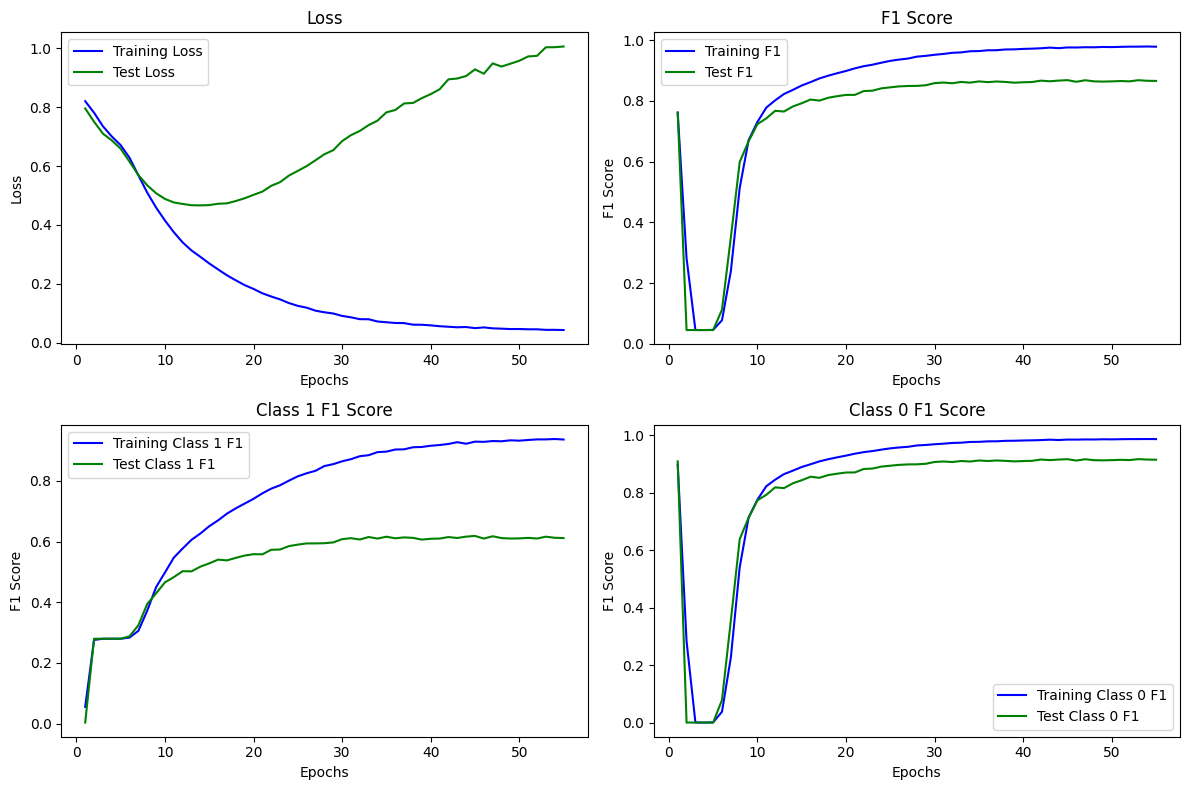

Evaluation Results:
Accuracy: 0.8634
F1 Score (Weighted): 0.8683
F1 Score for Class 1: 0.6185
Confusion Matrix:
[[5348, 603], [368, 787]]

FASTTEXT SIMPLE MLP Results:
Overall F1 score: 0.8683
Class 1 F1 score: 0.6185
Accuracy: 0.8634
Confusion Matrix:
[[5348, 603], [368, 787]]
Model saved to 'best_fasttext_mlp_simple.pt'
Model info saved to 'fasttext_mlp_simple_info.pkl'

Training with WORD2VEC embeddings
Loading embeddings from embedded_w2v.npy
Embeddings shape: (35225, 100)

----------------------------------------
Training SIMPLE MLP model
----------------------------------------
Total parameters: 18,172,038
Trainable parameters: 18,172,038
Epoch 1/100
Train Loss: 0.7696, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7535, Val F1: 0.0455, Val Class 1 F1: 0.2796
Epoch 2/100
Train Loss: 0.7506, Train F1: 0.0455, Train Class 1 F1: 0.2796
Val Loss: 0.7348, Val F1: 0.0455, Val Class 1 F1: 0.2796
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7311, Train F1: 0.0455

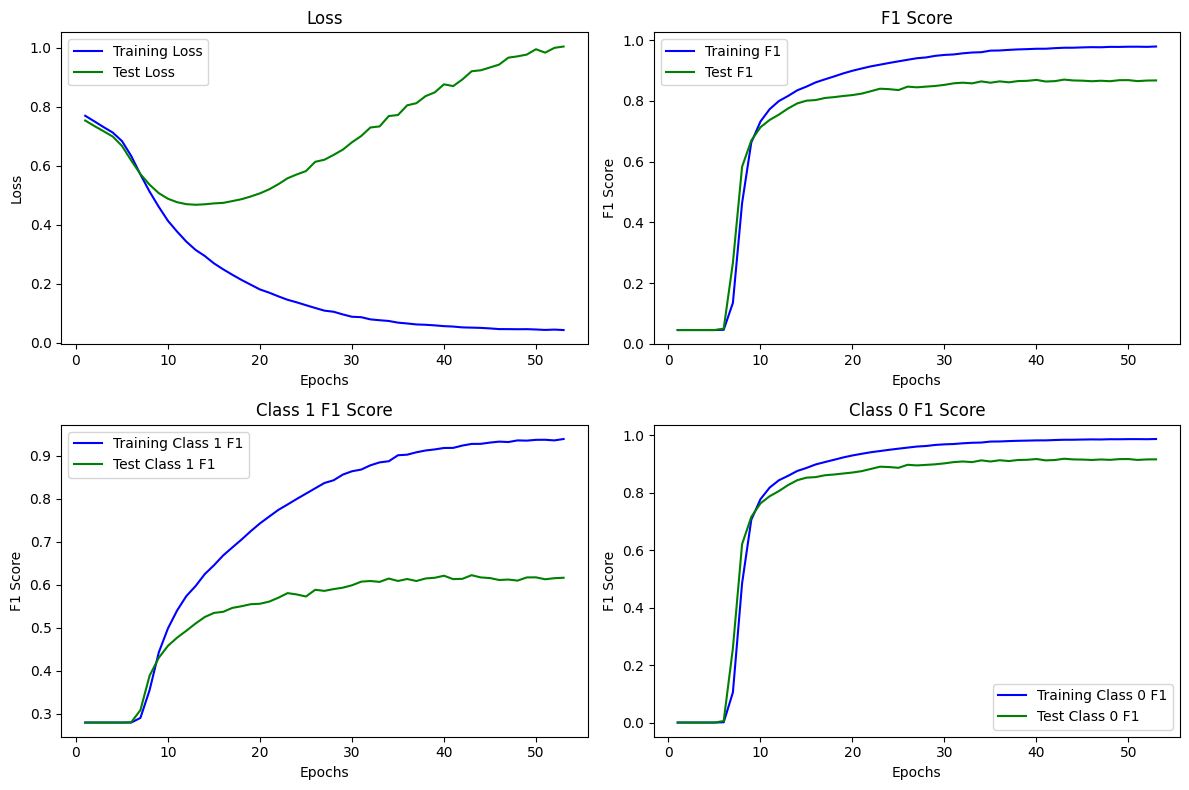

Evaluation Results:
Accuracy: 0.8660
F1 Score (Weighted): 0.8704
F1 Score for Class 1: 0.6222
Confusion Matrix:
[[5370, 581], [371, 784]]

WORD2VEC SIMPLE MLP Results:
Overall F1 score: 0.8704
Class 1 F1 score: 0.6222
Accuracy: 0.8660
Confusion Matrix:
[[5370, 581], [371, 784]]
Model saved to 'best_word2vec_mlp_simple.pt'
Model info saved to 'word2vec_mlp_simple_info.pkl'

TRAINING COMPLETED!
Generating comparison charts...


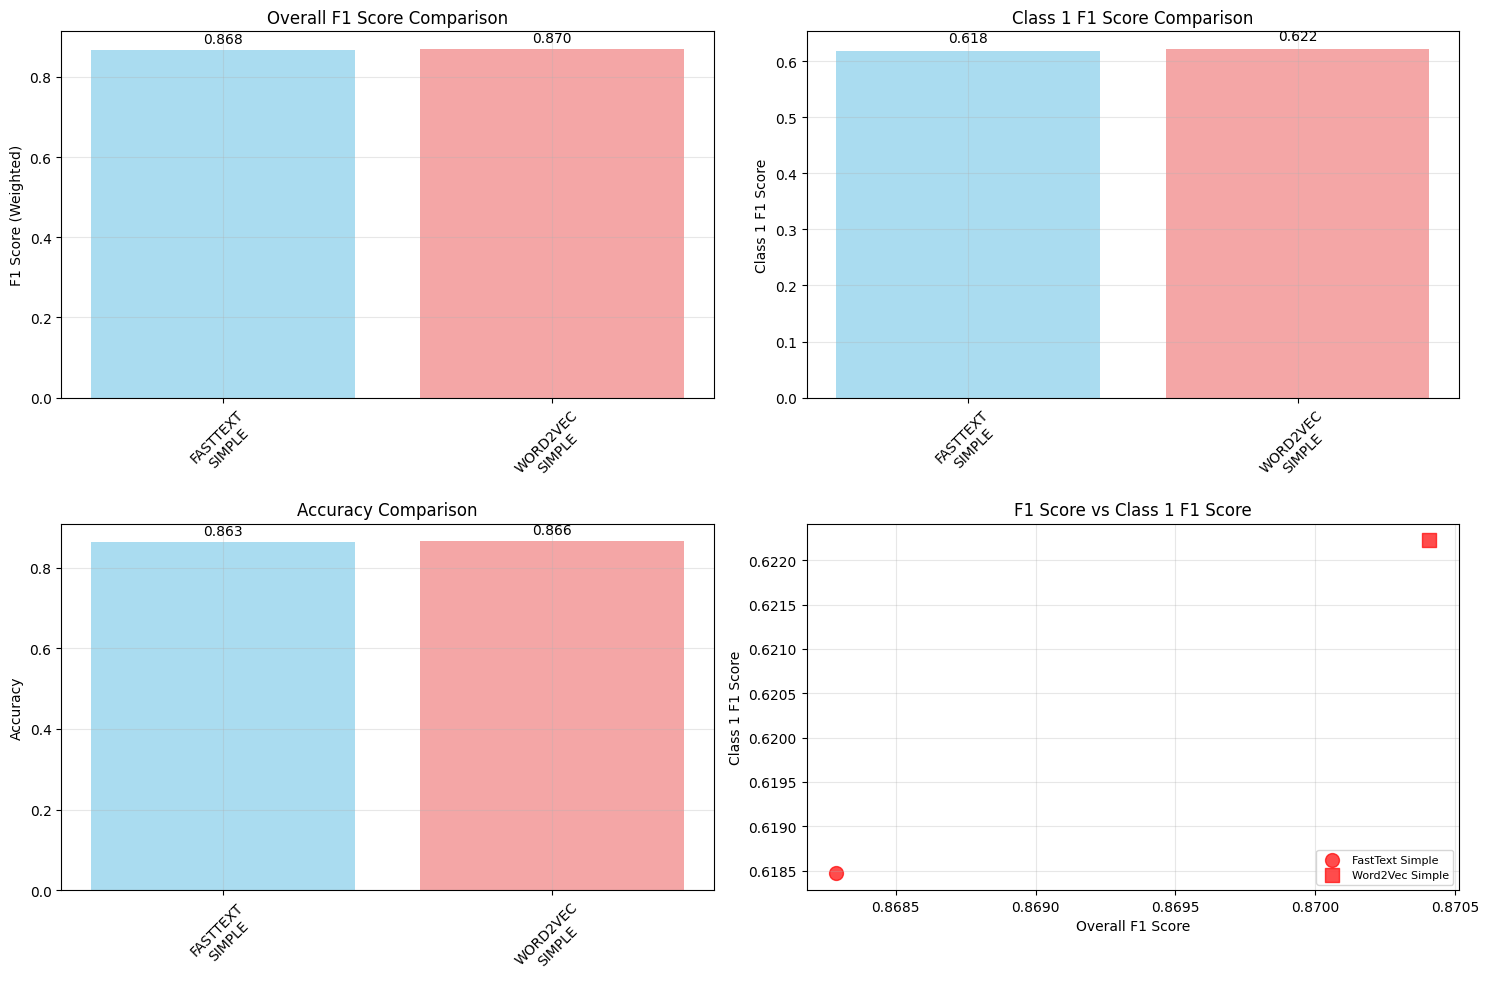


MLP MODEL COMPARISON SUMMARY
Model                     F1 Weighted  Class 1 F1   Accuracy  
-----------------------------------------------------------
fasttext_mlp_simple       0.8683       0.6185       0.8634    
word2vec_mlp_simple       0.8704       0.6222       0.8660    

Best Overall F1: word2vec_mlp_simple (0.8704)
Best Class 1 F1: word2vec_mlp_simple (0.6222)
Best Accuracy: word2vec_mlp_simple (0.8660)
All models trained and comparison completed!
Check the generated PNG files for visualizations.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import joblib
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
# İlk çalıştırmada gerekli
# nltk.download('punkt')

# Constants
BATCH_SIZE = 96
EPOCHS = 20
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_SEQ_LENGTH = 100  # Maksimum sequence uzunluğu
EMBEDDING_DIM = 300   # FastText/Word2Vec embedding boyutu

print(f"Using device: {DEVICE}")

class TextPreprocessor:
    def __init__(self, max_seq_length=MAX_SEQ_LENGTH):
        self.max_seq_length = max_seq_length
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2

    def clean_text(self, text):
        """Metni temizle"""
        text = text.lower()
        text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞIÖÇ\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize_text(self, text):
        """Metni tokenize et"""
        try:
            tokens = word_tokenize(text)
        except:
            # Eğer nltk tokenizer çalışmazsa basit split kullan
            tokens = text.split()
        return tokens

    def build_vocab_from_texts(self, texts):
        """Metinlerden vocabulary oluştur"""
        word_count = Counter()

        for text in texts:
            cleaned_text = self.clean_text(text)
            tokens = self.tokenize_text(cleaned_text)
            word_count.update(tokens)

        # Sadece 2'den fazla geçen kelimeleri al
        for word, count in word_count.items():
            if count >= 2 and word not in self.word_to_idx:
                self.word_to_idx[word] = self.vocab_size
                self.idx_to_word[self.vocab_size] = word
                self.vocab_size += 1

        print(f"Vocabulary size: {self.vocab_size}")

    def text_to_sequence(self, text):
        """Metni sequence'e çevir"""
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_text(cleaned_text)

        sequence = []
        for token in tokens:
            if token in self.word_to_idx:
                sequence.append(self.word_to_idx[token])
            else:
                sequence.append(self.word_to_idx['<UNK>'])

        # Padding veya truncation
        if len(sequence) > self.max_seq_length:
            sequence = sequence[:self.max_seq_length]
        else:
            sequence.extend([self.word_to_idx['<PAD>']] * (self.max_seq_length - len(sequence)))

        return sequence

    def texts_to_sequences(self, texts):
        """Birden fazla metni sequence'e çevir"""
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return np.array(sequences)

class EmbeddingLoader:
    def __init__(self, embedding_path, embedding_dim=EMBEDDING_DIM):
        self.embedding_path = embedding_path
        self.embedding_dim = embedding_dim
        self.embeddings = None

    def load_embeddings(self):
        """NPY dosyasından embeddings yükle"""
        print(f"Loading embeddings from {self.embedding_path}")
        self.embeddings = np.load(self.embedding_path)
        print(f"Embeddings shape: {self.embeddings.shape}")
        return self.embeddings

    def create_embedding_matrix(self, word_to_idx, vocab_size):
        """Vocabulary için embedding matrix oluştur"""
        if self.embeddings is None:
            self.load_embeddings()

        # Embedding matrix oluştur
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, self.embedding_dim))

        # <PAD> token için sıfır vektör
        embedding_matrix[0] = np.zeros(self.embedding_dim)

        # TODO: NPY dosyasının formatına göre embedding eşleştirmesi
        # Şu an random initialization kullanıyoruz

        return embedding_matrix.astype(np.float32)

# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight factor for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_softmax = F.log_softmax(inputs, dim=1)
        ce_loss = F.nll_loss(log_softmax, targets, weight=self.alpha, reduction='none')

        # Get the probabilities for the target class
        p_t = torch.exp(-ce_loss)

        # Apply the focusing term
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class EmbeddingMLPEnsemble(nn.Module):
    """
    FastText/Word2Vec embedding based MLP model.
    Aggregates word embeddings and passes through MLP layers.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix=None,
                 dropout_rate=DROPOUT_RATE, freeze_embeddings=True,
                 pooling_method='mean'):
        super(EmbeddingMLPEnsemble, self).__init__()

        self.pooling_method = pooling_method

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Pre-trained embeddings ile initialize et
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        # MLP layers
        self.dense1 = nn.Linear(embedding_dim, 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, 2)  # Binary classification

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, input_ids):
        # Embedding lookup
        embedded = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]

        # Create mask for non-padding tokens
        mask = (input_ids != 0).float().unsqueeze(-1)  # [batch_size, seq_len, 1]

        # Apply mask to embeddings
        masked_embedded = embedded * mask

        # Aggregate embeddings (pooling)
        if self.pooling_method == 'mean':
            # Calculate mean excluding padding tokens
            seq_lengths = mask.sum(dim=1)  # [batch_size, 1]
            pooled = masked_embedded.sum(dim=1) / (seq_lengths + 1e-8)  # [batch_size, embedding_dim]
        elif self.pooling_method == 'max':
            # Max pooling
            pooled, _ = masked_embedded.max(dim=1)  # [batch_size, embedding_dim]
        elif self.pooling_method == 'sum':
            # Sum pooling
            pooled = masked_embedded.sum(dim=1)  # [batch_size, embedding_dim]
        else:
            raise ValueError(f"Unknown pooling method: {self.pooling_method}")

        # MLP layers
        x = self.relu(self.dense1(pooled))
        x = self.dropout(x)

        x = self.relu(self.dense2(x))
        x = self.dropout(x)

        x = self.relu(self.dense3(x))
        x = self.dropout(x)

        # Classification
        logits = self.classifier(x)

        return logits

class EmbeddingMLPWithAttention(nn.Module):
    """
    MLP model with attention mechanism for better embedding aggregation.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix=None,
                 dropout_rate=DROPOUT_RATE, freeze_embeddings=True):
        super(EmbeddingMLPWithAttention, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Pre-trained embeddings ile initialize et
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        # Attention mechanism
        self.attention = nn.Linear(embedding_dim, 1)

        # MLP layers
        self.dense1 = nn.Linear(embedding_dim, 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, 2)  # Binary classification

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, input_ids):
        # Embedding lookup
        embedded = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]

        # Create mask for non-padding tokens
        mask = (input_ids != 0).float()  # [batch_size, seq_len]

        # Calculate attention weights
        attention_scores = self.attention(embedded).squeeze(-1)  # [batch_size, seq_len]

        # Mask attention scores for padding tokens
        attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, seq_len]

        # Apply attention weights to embeddings
        attention_weights = attention_weights.unsqueeze(-1)  # [batch_size, seq_len, 1]
        attended_embeddings = (embedded * attention_weights).sum(dim=1)  # [batch_size, embedding_dim]

        # MLP layers
        x = self.relu(self.dense1(attended_embeddings))
        x = self.dropout(x)

        x = self.relu(self.dense2(x))
        x = self.dropout(x)

        x = self.relu(self.dense3(x))
        x = self.dropout(x)

        # Classification
        logits = self.classifier(x)

        return logits

class EmbeddingDataset(Dataset):
    def __init__(self, sequences, labels=None):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.sequences[idx], dtype=torch.long)
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

class EarlyStoppingWithClassF1:
    def __init__(self, patience=5, min_delta=0.001, class_index=1, class_weight=0.5):
        """
        Early stopping that monitors both overall F1 and Class 1 F1 scores

        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change in monitored metrics to qualify as improvement
            class_index: Index of the class to monitor (1 for Class 1)
            class_weight: Weight given to class F1 vs overall F1 (0.5 means equal weight)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.class_index = class_index
        self.class_weight = class_weight
        self.counter = 0
        self.best_score = None
        self.best_class_f1 = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, model, val_overall_f1, val_class_f1s):
        """
        Args:
            model: Model to save if improvement
            val_overall_f1: Overall validation F1 score
            val_class_f1s: F1 scores for each class (list or array)
        """
        # Get the F1 score for the specific class we're monitoring
        class_f1 = val_class_f1s[self.class_index]

        # Calculate a combined score that considers both overall F1 and class F1
        combined_score = (1 - self.class_weight) * val_overall_f1 + self.class_weight * class_f1

        if self.best_score is None or self.best_class_f1 is None:
            # First epoch
            self.best_score = combined_score
            self.best_class_f1 = class_f1
            self.save_checkpoint(model)
        elif combined_score < self.best_score + self.min_delta:
            # Score didn't improve enough
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Score improved, but also check if Class 1 F1 didn't decrease significantly
            class_f1_decrease = self.best_class_f1 - class_f1

            # Only consider it an improvement if Class 1 F1 didn't drop too much
            if class_f1_decrease <= self.min_delta:
                print(f'Validation score improved! Overall F1: {val_overall_f1:.4f}, Class 1 F1: {class_f1:.4f}')
                self.best_score = combined_score
                self.best_class_f1 = class_f1
                self.save_checkpoint(model)
                self.counter = 0
            else:
                # Class 1 F1 dropped too much, don't reset counter
                print(f'Overall score improved but Class 1 F1 dropped too much (from {self.best_class_f1:.4f} to {class_f1:.4f})')
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        """Save model weights when validation performance improves"""
        self.best_weights = copy.deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        """Restore model to best weights"""
        model.load_state_dict(self.best_weights)

def train_model(model, train_dataloader, test_dataloader=None, class_weights=None, gamma=2.0,
                num_epochs=10, patience=3, class_f1_weight=0.6, learning_rate=2e-5):
    """
    Train model with Focal Loss and balanced early stopping

    Args:
        model: Model to train
        train_dataloader: Training data loader
        test_dataloader: Validation/test data loader
        class_weights: Dictionary mapping class indices to weights (e.g., {0: 1, 1: 6})
        gamma: Focal loss focusing parameter
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience
        class_f1_weight: Weight to give to Class 1 F1 score in early stopping
        learning_rate: Learning rate for optimizer

    Returns:
        trained_model: The trained model
        history: Dictionary containing training metrics
    """
    # Set up device
    device = next(model.parameters()).device

    # Create alpha tensor for focal loss based on class weights
    if class_weights is not None:
        num_classes = len(class_weights)
        alpha = torch.ones(num_classes)
        for cls_idx, weight in class_weights.items():
            alpha[cls_idx] = weight
        alpha = alpha.to(device)
    else:
        alpha = None

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up early stopping
    early_stopping = EarlyStoppingWithClassF1(
        patience=patience,
        class_index=1,  # Monitor Class 1 F1
        class_weight=class_f1_weight
    )

    # Track metrics
    history = {
        'train_loss': [],
        'train_f1': [],
        'train_class_f1s': [],
        'val_loss': [],
        'val_f1': [],
        'val_class_f1s': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store predictions and labels for metrics
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        train_loss = train_loss / len(train_dataloader)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_class_f1s = f1_score(train_labels, train_preds, average=None)

        # Save training metrics
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_class_f1s'].append(train_class_f1s.tolist())

        # Validation phase
        if test_dataloader is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels = []

            with torch.no_grad():
                for batch in test_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(input_ids)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()

                    # Store predictions and labels for metrics
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss = val_loss / len(test_dataloader)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            val_class_f1s = f1_score(val_labels, val_preds, average=None)

            # Save validation metrics
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_class_f1s'].append(val_class_f1s.tolist())

            # Print epoch results
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Class 1 F1: {val_class_f1s[1]:.4f}')

            # Early stopping check
            early_stopping(model, val_f1, val_class_f1s)

            if early_stopping.early_stop:
                print("Early stopping triggered")
                # Restore best weights
                early_stopping.restore_best_weights(model)
                break
        else:
            # Print training metrics when no validation set provided
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Class 1 F1: {train_class_f1s[1]:.4f}')

    # Load best weights if early stopping was used
    if test_dataloader is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)

    return model, history

def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model performance

    Args:
        model: Trained model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids)

            # Calculate loss if criterion provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_by_class': f1_score(all_labels, all_preds, average=None),
        'precision_weighted': precision_score(all_labels, all_preds, average='weighted'),
        'recall_weighted': recall_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds).tolist(),
        'classification_report': classification_report(all_labels, all_preds, output_dict=True)
    }

    # Add loss if criterion was provided
    if criterion is not None:
        metrics['loss'] = total_loss / len(dataloader)

    # Print key metrics
    print(f"Evaluation Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score for Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics

def plot_training_history(history):
    """Eğitim sürecindeki metriklerin grafiklerini çiz"""
    epochs = range(1, len(history["train_loss"]) + 1)

    # Eğer val_loss yoksa, sadece train metriklerini çizdir
    has_test = "val_loss" in history and len(history["val_loss"]) > 0

    # Loss grafiği
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Training Loss')
    if has_test:
        plt.plot(epochs, history["val_loss"], 'g-', label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1 grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history["train_f1"], 'b-', label='Training F1')
    if has_test:
        plt.plot(epochs, history["val_f1"], 'g-', label='Test F1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class 1 F1 grafiği
    plt.subplot(2, 2, 3)
    class1_f1_train = [f1s[1] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, class1_f1_train, 'b-', label='Training Class 1 F1')
    if has_test:
        class1_f1_val = [f1s[1] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, class1_f1_val, 'g-', label='Test Class 1 F1')
    plt.title('Class 1 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Class 0 F1 grafiği
    plt.subplot(2, 2, 4)
    class0_f1_train = [f1s[0] for f1s in history["train_class_f1s"]]
    plt.plot(epochs, class0_f1_train, 'b-', label='Training Class 0 F1')
    if has_test:
        class0_f1_val = [f1s[0] for f1s in history["val_class_f1s"]]
        plt.plot(epochs, class0_f1_val, 'g-', label='Test Class 0 F1')
    plt.title('Class 0 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('embedding_mlp_training_history.png')
    plt.show()

def visualize_attention_weights(model, sample_sequences, preprocessor, num_samples=3):
    """Attention ağırlıklarını görselleştir (sadece attention modellerinde çalışır)"""
    if not hasattr(model, 'attention'):
        print("Bu model attention mekanizmasına sahip değil.")
        return

    device = next(model.parameters()).device
    model.eval()

    plt.figure(figsize=(15, num_samples * 4))

    with torch.no_grad():
        for i, sequence in enumerate(sample_sequences[:num_samples]):
            input_tensor = torch.tensor([sequence], dtype=torch.long).to(device)

            # Embedding lookup
            embedded = model.embedding(input_tensor)  # [1, seq_len, embedding_dim]

            # Create mask for non-padding tokens
            mask = (input_tensor != 0).float()  # [1, seq_len]

            # Calculate attention weights
            attention_scores = model.attention(embedded).squeeze(-1)  # [1, seq_len]
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
            attention_weights = F.softmax(attention_scores, dim=1)  # [1, seq_len]

            # Get actual words from sequence
            words = []
            attention_vals = []
            for j, token_id in enumerate(sequence):
                if token_id != 0:  # Not padding
                    if token_id in preprocessor.idx_to_word:
                        words.append(preprocessor.idx_to_word[token_id])
                    else:
                        words.append('<UNK>')
                    attention_vals.append(attention_weights[0, j].cpu().numpy())

            # Plot attention weights
            plt.subplot(num_samples, 1, i+1)
            plt.bar(range(len(attention_vals)), attention_vals)
            plt.title(f'Sample {i+1}: Attention Weights')
            plt.xlabel('Words')
            plt.ylabel('Attention Weight')

            # Show words on x-axis if not too many
            if len(words) < 20:
                plt.xticks(range(len(words)), words, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('mlp_attention_weights.png', dpi=300, bbox_inches='tight')
    plt.show()

# ANA KOD - FastText ve Word2Vec ile eğitim
def main():
    # Load data
    df = pd.read_csv('dataset.csv')
    texts = df["text"].values.tolist()
    labels = df["label"].values.tolist()

    print(f"Total samples: {len(texts)}")
    print(f"Label distribution: {Counter(labels)}")

    # Text preprocessing
    preprocessor = TextPreprocessor(max_seq_length=MAX_SEQ_LENGTH)
    preprocessor.build_vocab_from_texts(texts)

    # Convert texts to sequences
    sequences = preprocessor.texts_to_sequences(texts)
    print(f"Sequences shape: {sequences.shape}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        sequences, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # FastText ve Word2Vec için ayrı ayrı eğitim
    embedding_types = ['fasttext', 'word2vec']
    embedding_files = {
        'fasttext': 'embedded_fasttext.npy',  # FastText .npy dosyanızın adı
        'word2vec': 'embedded_w2v.npy'   # Word2Vec .npy dosyanızın adı
    }

    # Model türleri
    model_types = ['simple']

    for embedding_type in embedding_types:
        print(f"\n{'='*60}")
        print(f"Training with {embedding_type.upper()} embeddings")
        print(f"{'='*60}")

        # Embeddings yükle
        embedding_loader = EmbeddingLoader(embedding_files[embedding_type])
        embedding_matrix = embedding_loader.create_embedding_matrix(
            preprocessor.word_to_idx,
            preprocessor.vocab_size
        )

        # Dataset ve DataLoader oluştur
        train_dataset = EmbeddingDataset(X_train, y_train)
        test_dataset = EmbeddingDataset(X_test, y_test)

        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

        for model_type in model_types:
            print(f"\n{'-'*40}")
            print(f"Training {model_type.upper()} MLP model")
            print(f"{'-'*40}")

            # Model seçimi
            if model_type == 'simple':
                model = EmbeddingMLPEnsemble(
                    vocab_size=preprocessor.vocab_size,
                    embedding_dim=EMBEDDING_DIM,
                    embedding_matrix=embedding_matrix,
                    dropout_rate=DROPOUT_RATE,
                    freeze_embeddings=False,  # Embedding'leri fine-tune et
                    pooling_method='mean'  # mean pooling kullan
                ).to(DEVICE)
                model_name = f"{embedding_type}_mlp_simple"
            else:  # attention
                model = EmbeddingMLPWithAttention(
                    vocab_size=preprocessor.vocab_size,
                    embedding_dim=EMBEDDING_DIM,
                    embedding_matrix=embedding_matrix,
                    dropout_rate=DROPOUT_RATE,
                    freeze_embeddings=False  # Embedding'leri fine-tune et
                ).to(DEVICE)
                model_name = f"{embedding_type}_mlp_attention"

            # Model parametrelerini göster
            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Total parameters: {total_params:,}")
            print(f"Trainable parameters: {trainable_params:,}")

            # Class weights and Focal Loss parameters
            class_weights = {0: 1, 1: 6}  # Adjust based on your dataset
            gamma = 2.0  # Focal Loss focusing parameter

            # Train model
            trained_model, history = train_model(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                class_weights=class_weights,
                gamma=gamma,
                num_epochs=100,
                patience=10,
                class_f1_weight=0.6,
                learning_rate=LEARNING_RATE
            )

            # Plot training history
            plot_training_history(history)

            # Attention visualization for attention models
            if model_type == 'attention':
                sample_sequences = X_test[:3]  # İlk 3 test sample'ı
                visualize_attention_weights(trained_model, sample_sequences, preprocessor, num_samples=3)

            # Final evaluation
            focal_loss = FocalLoss(
                alpha=torch.tensor([1, 6]).float().to(DEVICE),
                gamma=gamma
            )
            test_metrics = evaluate_model(trained_model, test_dataloader, focal_loss)

            # Save results
            print(f"\n{embedding_type.upper()} {model_type.upper()} MLP Results:")
            print(f"Overall F1 score: {test_metrics['f1_weighted']:.4f}")
            print(f"Class 1 F1 score: {test_metrics['f1_by_class'][1]:.4f}")
            print(f"Accuracy: {test_metrics['accuracy']:.4f}")
            print(f"Confusion Matrix:")
            print(test_metrics['confusion_matrix'])

            # Save model
            torch.save(trained_model.state_dict(), f'best_{model_name}.pt')

            # Save model info
            model_info = {
                'embedding_type': embedding_type,
                'model_type': f'mlp_{model_type}',
                'vocab_size': preprocessor.vocab_size,
                'embedding_dim': EMBEDDING_DIM,
                'max_seq_length': MAX_SEQ_LENGTH,
                'dropout_rate': DROPOUT_RATE,
                'test_metrics': test_metrics,
                'word_to_idx': preprocessor.word_to_idx,
                'idx_to_word': preprocessor.idx_to_word
            }
            joblib.dump(model_info, f'{model_name}_info.pkl')

            print(f"Model saved to 'best_{model_name}.pt'")
            print(f"Model info saved to '{model_name}_info.pkl'")

def compare_mlp_models():
    """MLP model sonuçlarını karşılaştır"""
    model_names = [
        'fasttext_mlp_simple',
        'word2vec_mlp_simple'
    ]

    results = {}

    # Model bilgilerini yükle
    for model_name in model_names:
        try:
            info = joblib.load(f'{model_name}_info.pkl')
            results[model_name] = info['test_metrics']
        except FileNotFoundError:
            print(f"Warning: {model_name}_info.pkl not found")

    if not results:
        print("No model results found for comparison")
        return

    # Comparison visualization
    plt.figure(figsize=(15, 10))

    # Prepare data
    models = list(results.keys())
    f1_scores = [results[model]['f1_weighted'] for model in models]
    class1_f1_scores = [results[model]['f1_by_class'][1] for model in models]
    accuracies = [results[model]['accuracy'] for model in models]

    # Clean model names for display
    display_names = []
    for name in models:
        parts = name.split('_')
        embedding = parts[0].upper()
        model_type = parts[2].upper()
        display_names.append(f"{embedding}\n{model_type}")

    # Overall F1 Score comparison
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(display_names, f1_scores, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('Overall F1 Score Comparison')
    plt.ylabel('F1 Score (Weighted)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, score in zip(bars1, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    # Class 1 F1 Score comparison
    plt.subplot(2, 2, 2)
    bars2 = plt.bar(display_names, class1_f1_scores, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('Class 1 F1 Score Comparison')
    plt.ylabel('Class 1 F1 Score')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, score in zip(bars2, class1_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    # Accuracy comparison
    plt.subplot(2, 2, 3)
    bars3 = plt.bar(display_names, accuracies, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, score in zip(bars3, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    # Scatter plot: F1 vs Class 1 F1
    plt.subplot(2, 2, 4)
    colors = ['red', 'red', 'blue', 'blue']
    markers = ['o', 's', 'o', 's']
    labels = ['FastText Simple', 'Word2Vec Simple']

    for i, (f1, class1_f1, label) in enumerate(zip(f1_scores, class1_f1_scores, labels)):
        plt.scatter(f1, class1_f1, c=colors[i], marker=markers[i], s=100, alpha=0.7, label=label)

    plt.xlabel('Overall F1 Score')
    plt.ylabel('Class 1 F1 Score')
    plt.title('F1 Score vs Class 1 F1 Score')
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('mlp_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary table
    print(f"\n{'='*60}")
    print("MLP MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"{'Model':<25} {'F1 Weighted':<12} {'Class 1 F1':<12} {'Accuracy':<10}")
    print(f"{'-'*59}")

    for model, metrics in results.items():
        f1_weighted = metrics['f1_weighted']
        class1_f1 = metrics['f1_by_class'][1]
        accuracy = metrics['accuracy']
        print(f"{model:<25} {f1_weighted:<12.4f} {class1_f1:<12.4f} {accuracy:<10.4f}")

    # Find best models
    best_f1_model = max(results.items(), key=lambda x: x[1]['f1_weighted'])
    best_class1_model = max(results.items(), key=lambda x: x[1]['f1_by_class'][1])
    best_accuracy_model = max(results.items(), key=lambda x: x[1]['accuracy'])

    print(f"\nBest Overall F1: {best_f1_model[0]} ({best_f1_model[1]['f1_weighted']:.4f})")
    print(f"Best Class 1 F1: {best_class1_model[0]} ({best_class1_model[1]['f1_by_class'][1]:.4f})")
    print(f"Best Accuracy: {best_accuracy_model[0]} ({best_accuracy_model[1]['accuracy']:.4f})")

if __name__ == "__main__":
    print(f"Starting MLP model training with FastText and Word2Vec embeddings...")
    print(f"Device: {DEVICE}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Max epochs: {EPOCHS}")

    # Run main training
    main()

    print(f"\n{'='*60}")
    print("TRAINING COMPLETED!")
    print(f"{'='*60}")

    # Compare results
    print("Generating comparison charts...")
    compare_mlp_models()

    print("All models trained and comparison completed!")
    print("Check the generated PNG files for visualizations.")